# Set-ups

In [ ]:
# %%capture
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/MyDrive/COMP576/training-logs/tensorboard')

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import matplotlib.pyplot as plt

import re
import os
import time
import datetime
from pytz import timezone

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow.keras as keras
# from tensorflow.keras import layers, models

tf.config.list_physical_devices('GPU')
!nvidia-smi

!pip install importnb
# import our preprocessing from ipynb
import sys
sys.path.append('drive/MyDrive/COMP576/final-project')
from importnb import Notebook
with Notebook():
    import KDR_Preprocessing as prep
    import Model_Architecture_List as myModel

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Sun Dec 11 14:32:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    49W / 400W |      3MiB / 40536MiB |     25%      Default |
|                               |                      |             Disabled |
+-------------------------------+----

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputA (InputLayer)            [(None, 40, 40, 71)  0           []                               
                                ]                                                                 
                                                                                                  
 inputB (InputLayer)            [(None, 40, 40, 71)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 38, 38, 32)   20480       ['inputA[0][0]']                 
                                                                                              

## Tensorboard Codes

In [ ]:
# %load_ext tensorboard

# # Clear any logs from previous runs
# rm -rf ./logs/

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# %tensorboard --logdir logs/fit

# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

# # Control TensorBoard display. If no port is provided, 
# # the most recently launched TensorBoard is used
# notebook.display(port=6006, height=1000)
# # !kill portPID#

# STREAMLINE FUNCTIONS

In [ ]:
def prep_main(folder_path, sample_size, train_size, dev_size):
    data, train_data, dev_data, test_data, KEYCODE_enc, K1_K2_enc, K1_enc, K2_enc = prep.processing_folder(folder_path, sample_size, train_size, dev_size)
    train_extractor = prep.Extractor(train_data)
    dev_extractor = prep.Extractor(dev_data)
    test_extractor = prep.Extractor(test_data)
    return data, train_data, dev_data, test_data, KEYCODE_enc, K1_K2_enc, K1_enc, K2_enc, train_extractor, dev_extractor, test_extractor

def prep_feature_df(train_extractor, dev_extractor, test_extractor,
                    graph_mode, avg_mode, encode_keyboard, filter, bounds_dict):
    if graph_mode == 'unigraph':
        if filter:
            train_df = train_extractor.unigraph_filtered(avg_mode, encode_keyboard, filter, bounds_dict)
            dev_df = dev_extractor.unigraph_filtered(avg_mode, encode_keyboard, filter, bounds_dict)
            test_df = test_extractor.unigraph_filtered(avg_mode, encode_keyboard, filter, bounds_dict)
        elif encode_keyboard:
            train_df = train_extractor.unigraph_keyboard(avg_mode)
            dev_df = dev_extractor.unigraph_keyboard(avg_mode)
            test_df = test_extractor.unigraph_keyboard(avg_mode)
        elif avg_mode:
            train_df = train_extractor.unigraph_avg(avg_mode)
            dev_df = dev_extractor.unigraph_avg(avg_mode)
            test_df = test_extractor.unigraph_avg(avg_mode)
        else:
            train_df = train_extractor.unigraph
            dev_df = dev_extractor.unigraph
            test_df = test_extractor.unigraph
    else:
        if filter:
            train_df = train_extractor.digraph_filtered(avg_mode, encode_keyboard, filter, bounds_dict)
            dev_df = dev_extractor.digraph_filtered(avg_mode, encode_keyboard, filter, bounds_dict)
            test_df = test_extractor.digraph_filtered(avg_mode, encode_keyboard, filter, bounds_dict)
        elif encode_keyboard:
            train_df = train_extractor.digraph_keyboard(avg_mode)
            dev_df = dev_extractor.digraph_keyboard(avg_mode)
            test_df = test_extractor.digraph_keyboard(avg_mode)
        elif avg_mode:
            train_df = train_extractor.digraph_avg(avg_mode)
            dev_df = dev_extractor.digraph_avg(avg_mode)
            test_df = test_extractor.digraph_avg(avg_mode)
        else:
            train_df = train_extractor.digraph
            dev_df = dev_extractor.digraph
            test_df = test_extractor.digraph
    return train_df, dev_df, test_df

def prep_tfds(train_data, input_format, train_df, dev_df, test_df,
              n_steps, shift, batch_size, encoders, output_features,
              enc_names, nonkeycodeB_features, graph_mode,
              mat_length, inputA_features, inputB_features):
    if input_format == 'KDS':
        train_KD = prep.KDS(train_df, 
                             n_steps, shift, batch_size, 
                             nonkeycodeB_features, output_features, 
                             encoders, enc_names)
        dev_KD = prep.KDS(dev_df, 
                           n_steps, shift, batch_size, 
                           nonkeycodeB_features, output_features, 
                           encoders, enc_names)
        test_KD = prep.KDS(test_df, 
                            n_steps, shift, batch_size, 
                            nonkeycodeB_features, output_features, 
                            encoders, enc_names)
        trainset = train_KD.ds
        devset = dev_KD.ds
        testset = test_KD.ds
    else:
        train_KD = prep.KDI(train_data, train_df,
                             n_steps, shift, batch_size,
                             mat_length, inputA_features, inputB_features, 
                             output_features)
        dev_KD = prep.KDI(train_data, dev_df,
                           n_steps, shift, batch_size,
                           mat_length, inputA_features, inputB_features, 
                           output_features)
        test_KD = prep.KDI(train_data, test_df,
                            n_steps, shift, batch_size,
                            mat_length, inputA_features, inputB_features, 
                            output_features)
        trainset = train_KD.ds
        devset = dev_KD.ds
        testset = test_KD.ds
    return trainset, devset, testset, train_KD, test_KD

def pretraining_check(data, train_data, dev_data, test_data,
                      train_df, 
                      encoders, enc_names, input_format, graph_mode,
                      input_features, output_features, train_KD):
    ## prep_main() checking
    prep.preprocess_message(data, 'total_data')
    prep.preprocess_message(train_data, 'train_data')
    prep.preprocess_message(dev_data, 'dev_data')
    prep.preprocess_message(test_data, 'test_data')

    ## prep_feature_df checking
    print(f"\n\ntrain_df.head(1): \n {train_df.head(1)}")
    print(f"train_df.describe: \n {train_df.describe()}\n\n")

    ## prep_tfds checking
    if encoders:
        print(f"encoder = {enc_names}, with {len(encoders[0].categories_[0])} many categories.")
    print(f"encoded input features include: {['K1, K2'] if graph_mode == 'digraph' else ['KEYCODE']}, {input_features[0]+input_features[1] if len(input_features)>1 else input_features[0]}")
    print(f"encoded output features include: {output_features}\n\n")
    if input_format == 'KDS':
        print(f"train_kds.inputA shape: {train_KD.inputA}, \
                \ntrain_kds.inputB shape: {train_KD.inputB}, \
                \ntrain_kds.output shape: {train_KD.output}")
    else:
        print(f"train_kdi.inputA shape: {train_KD.inputA.shape}, \
                \ntrain_kdi.inputB shape: {train_KD.inputB.shape}, \
                \ntrain_kdi.output shape: {train_KD.output.shape}")

def main_training(model_name, train_id, model_structure,
                  input_format, train_KD,
                  optimizer, loss, metrics, l1_reg, mat_length,
                  trainset, devset, EPOCHS, callbacks,
                  figsize=(12,8)):
    if input_format == 'KDS':
        feature_dim = train_KD.inputA[-1]
        output_dim = train_KD.output[-1]
        model = model_structure(feature_dim, 
                                output_dim)
    elif input_format == 'KDI' and l1_reg:
        inputA_feature_dim = train_KD.inputA.shape[-1]
        inputB_feature_dim = train_KD.inputB.shape[-1]
        output_dim = train_KD.output.shape[-1]
        model = model_structure(inputA_feature_dim,
                                inputB_feature_dim,
                                output_dim,
                                mat_length,
                                l1_reg)
    else:
        inputA_feature_dim = train_KD.inputA.shape[-1]
        inputB_feature_dim = train_KD.inputB.shape[-1]
        output_dim = train_KD.output.shape[-1]
        model = model_structure(inputA_feature_dim,
                                inputB_feature_dim,
                                output_dim,
                                mat_length)
    
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)

    start_time = time.time()
    history = model.fit(trainset, epochs=EPOCHS, validation_data=devset, callbacks=callbacks)
    end_time = time.time()
    print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
    pd.DataFrame(history.history).plot(figsize=figsize, title=train_id);
    if 'lr' in list(history.history.keys()):
        print("\n\nreach lr but cannot plot\n\n")
        prep.lr_vs_loss(history);
    return model, history

def print_results(model, testset, input_format, test_KD, output_features):
    eval_results = model.evaluate(testset)
    if input_format == 'KDS':
        for a, b in test_KD.ds_in.take(1):
            inputA = a
            inputB = b
        for a in test_KD.ds_out.take(1):
            y_true = a
    else:
        for a, b in testset.take(1):
            inputA = a['inputA']
            inputB = a['inputB']
            y_true = b
    y_pred = model.predict((inputA, inputB))
    diff = pd.DataFrame(np.round(np.abs(y_true - y_pred)))
    diff.columns = output_features
    print(f"The evaluation results are: \n Loss: {eval_results[0]}\n Metrics: {eval_results[1:]}\n")
    print(diff.describe())
    return eval_results, diff

# START TRAINING

In [ ]:
## prep_main
folder_path = "/content/drive/MyDrive/COMP576/keystroke-samples"      ## up to USER=7001 (inclusive)
sample_size = 400
train_size = 0.7
dev_size = 0.15
data, train_data, dev_data, test_data, KEYCODE_enc, K1_K2_enc, K1_enc, K2_enc, train_extractor, dev_extractor, test_extractor = prep_main(folder_path, sample_size, train_size, dev_size)

## prep_feature_df
graph_mode = 'digraph'
avg_mode = None
encode_keyboard = True
### 'ABS', 'IQR'
filter = 'ABS'
### uni == {'HL':[], 'PL':[], 'IL':[], 'RL':[]}
### di == {'HL1':[], 'HL2':[], 'PL':[], 'IL':[], 'RL':[]}
bounds_dict = {'HL1':[3, 3], 'HL2':[3, 3], 'PL':[0, 10], 'IL':[3, 3], 'RL':[3, 3]}
train_df, dev_df, test_df = prep_feature_df(train_extractor, dev_extractor, test_extractor,
                                            graph_mode, avg_mode, encode_keyboard, filter, bounds_dict)

## prep_tfds
### 'KDS', 'KDI'
input_format = 'KDI'
n_steps = 60
shift = 1
batch_size = 32
### [KEYCODE_enc], [K1_K2_enc], [K1_enc, K2_enc], None
encoders = None
if graph_mode == 'unigraph':
    output_features = ['HL', 'PL']
else:
    output_features = ['HL2', 'PL']
### ['KEYCODE'], ['K1_K2'], ['K1', 'K2']
enc_names = ['K1_K2']
nonkeycodeB_features = ['I1', 'I2', 'HL1']
### True(default), False
# do_onehot = True
mat_length = 40
inputA_features = ['I1', 'HD', 'KD', 'IL', 'RL', 'PL', 'HL']
inputB_features = ['I1', 'HD', 'KD']
### 'image'(default), 'one-hot', 'label'
# inputB_type = 'image'
### True, False(default)
# keep_smaller_window = False
### True(default), False
# add_UNK = True
trainset, devset, testset, train_KD, test_KD = prep_tfds(train_data, input_format, train_df, dev_df, test_df,
                                                         n_steps, shift, batch_size, encoders, output_features,
                                                         enc_names, nonkeycodeB_features, graph_mode,
                                                         mat_length, inputA_features, inputB_features)

## Pretraining CHECKS!!!!!
if input_format == 'KDS':
    input_features = [nonkeycodeB_features]
else:
    input_features = [inputA_features, inputB_features]
pretraining_check(data, train_data, dev_data, test_data,
                  train_df, 
                  encoders, enc_names, input_format, graph_mode,
                  input_features, output_features, train_KD)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI_LeNet5_Dense-64-2-Reg/20221209-175639
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI_LeNet5_Dense-64-2-Reg/20221209-175639
Epoch 1/30
2631/2631 [==============================] - 22s 8ms/step - loss: 76.9404 - mae: 74.1000 - val_loss: 53.5976 - val_mae: 51.3769
Epoch 2/30
2631/2631 [==============================] - 20s 8ms/step - loss: 72.4665 - mae: 70.7011 - val_loss: 52.4131 - val_mae: 50.9358
Epoch 3/30
2631/2631 [==============================] - 20s 8ms/step - loss: 70.6852 - mae: 69.4370 - val_loss: 53.2355 - val_mae: 52.0915
Epoch 4/30
2631/2631 [==============================] - 20s 8ms/step - loss: 69.7290 - mae: 68.6909 - val_loss: 53.2533 - val_mae: 52.2353
Epoch 5/30
2631/2631 [==============================] - 21s 8ms/step - loss: 68.8704 - mae: 67.8960 - val_loss: 51.5664 - val_mae: 50.5913
Epoch 6/30
2631/2631 [=======================

2/2 [==============================] - 0s 7ms/step
The evaluation results are: 
 Loss: 45.123775482177734
 Metrics: [44.132991790771484]

       HL2    PL
count 64.0  64.0
mean  13.7  75.2
std   10.0  89.1
min    0.0   1.0
25%    5.8  21.0
50%   11.5  40.0
75%   19.2  92.0
max   43.0 382.0


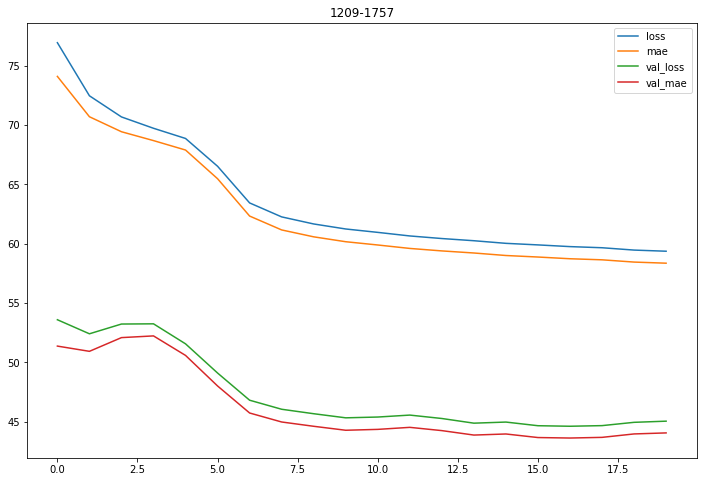

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
train_id = '1209-1757'
model_name = 'KDI_LeNet5_Dense-64-2-Reg'
model_structure = myModel.create_model_6
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
l1_reg = 0.001
# loss = tf.keras.losses.LogCosh()
loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 30
patience = 3
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

In [ ]:
diff

,HL2,PL
0,8.0,24.0
1,4.0,15.0
2,21.0,27.0
3,13.0,40.0
4,14.0,42.0
...,...,...
59,8.0,90.0
60,5.0,79.0
61,26.0,189.0
62,2.0,38.0


# Trying out whether predicting HL and PL separately helps

## Non-Avg Users -- Keycode To Time

In [ ]:
def keycodeTotime_prep(uni_df, latency, window_length, shift, batch_size):
    df = np.concatenate([KEYCODE_enc.transform(uni_df[['KEYCODE']]).toarray(), uni_df[['INDEX', latency]]], axis=1)
    ds = tf.data.Dataset.from_tensor_slices(df).window(size=window_length, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_length)).batch(batch_size)
    ds = ds.map(lambda windows: (windows[:, :, :-1], windows[:, :, -1]))
    return ds

In [ ]:
train_uni_df = train_extractor.unigraph
dev_uni_df = dev_extractor.unigraph
test_uni_df = test_extractor.unigraph

In [ ]:
train_uni_df.head(2)

,USER,KEYCODE,INDEX,HL,IL,RL,PL
0,5,16,0.0,168.0,-59.0,0.0,109.0
1,5,84,1.0,59.0,78.0,150.0,137.0


In [ ]:
len(train_uni_df['USER'].unique())

500

In [ ]:
latency = 'PL'
window_length = 40
shift = 1
batch_size = 32
train_uni_ds = keycodeTotime_prep(train_uni_df, latency, window_length, shift, batch_size)
dev_uni_ds = keycodeTotime_prep(dev_uni_df, latency, window_length, shift, batch_size)
test_uni_ds = keycodeTotime_prep(test_uni_df, latency, window_length, shift, batch_size)

In [ ]:
for a, b in train_uni_ds.take(1):
    print(a.shape, b.shape)
    features_dim = a.shape[-1]
    output_dim = 1

(32, 40, 72) (32, 40)


Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221209-200936
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221209-200936
Epoch 1/30
1591/1591 [==============================] - 158s 97ms/step - loss: 254.7604 - mae: 255.4532 - val_loss: 245.2903 - val_mae: 245.9836 - lr: 7.0000e-05
Epoch 2/30
1591/1591 [==============================] - 154s 97ms/step - loss: 235.8544 - mae: 236.5472 - val_loss: 224.6803 - val_mae: 225.3732 - lr: 1.0000e-04
Epoch 3/30
1591/1591 [==============================] - 154s 97ms/step - loss: 192.4873 - mae: 193.1779 - val_loss: 166.1058 - val_mae: 166.7948 - lr: 4.0000e-04
Epoch 4/30
1591/1591 [==============================] - 155s 98ms/step - loss: 155.8961 - mae: 156.5854 - val_loss: 148.6994 - val_mae: 149.3902 - lr: 7.0000e-04
Epoch 5/30
1591/1591 [==============================] - 155s 97ms/step - loss: 151.0145 - mae: 151.7042 - val_lo

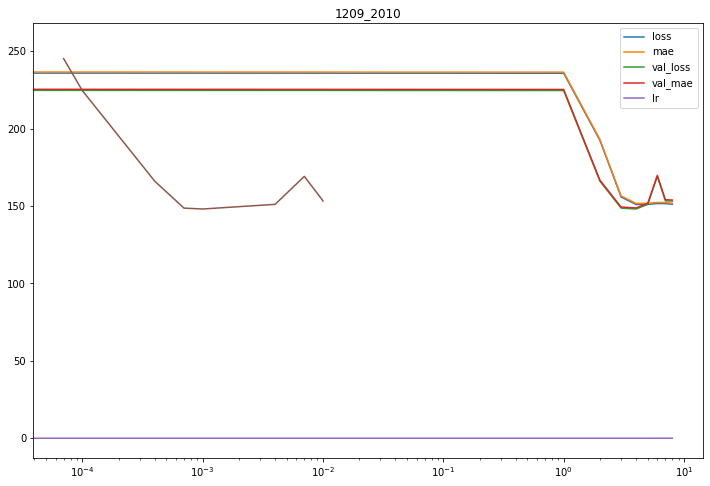

In [ ]:
## 100 users. ##PL 
train_id = '1209_2010'
model_keyTotime_PL = myModel.create_model_keyTOtime(features_dim, output_dim)
model_name = 'Keycode_TO_Time'

model_keyTotime_PL.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.LogCosh(),
              metrics=['mae'])

lr_scheduler = prep.create_lr_scheduler(0.01)
EPOCHS = 30
callbacks = prep.get_callbacks(model_name, 4, False)
callbacks = callbacks + [lr_scheduler]

start_time = time.time()
history_keyTotime_PL = model_keyTotime_PL.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_PL.history).plot(figsize=(12,8), title=train_id);
if 'lr' in list(history_keyTotime_PL.history.keys()):
    print("\n\nreach lr\n\n")
    prep.lr_vs_loss(history_keyTotime_PL);

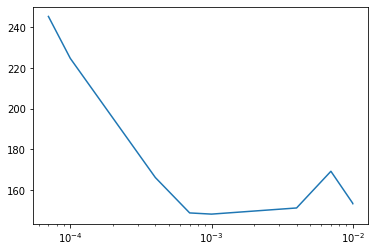

In [ ]:
prep.lr_vs_loss(history_keyTotime_PL)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221209-204713
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221209-204713
Epoch 1/30
1591/1591 [==============================] - 166s 102ms/step - loss: 213.3088 - mae: 214.0004 - val_loss: 172.8043 - val_mae: 173.4949
Epoch 2/30
1591/1591 [==============================] - 157s 98ms/step - loss: 159.8297 - mae: 160.5184 - val_loss: 150.0326 - val_mae: 150.7225
Epoch 3/30
1591/1591 [==============================] - 157s 98ms/step - loss: 151.5330 - mae: 152.2225 - val_loss: 147.9192 - val_mae: 148.6102
Epoch 4/30
1591/1591 [==============================] - 156s 98ms/step - loss: 150.8798 - mae: 151.5701 - val_loss: 147.7230 - val_mae: 148.4130
Epoch 5/30
1591/1591 [==============================] - 156s 98ms/step - loss: 150.8383 - mae: 151.5287 - val_loss: 147.6889 - val_mae: 148.3791
Epoch 6/30
1591/1591 [============

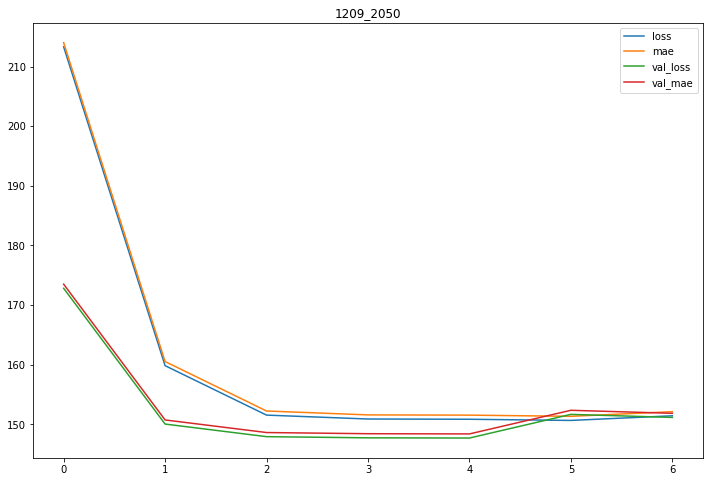

In [ ]:
## 100 users. ##PL 
train_id = '1209_2050'
model_keyTotime_PL_1 = myModel.create_model_keyTOtime(features_dim, output_dim)
model_name = 'Keycode_TO_Time'

model_keyTotime_PL_1.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.LogCosh(),
              metrics=['mae'])

# lr_scheduler = prep.create_lr_scheduler(0.01)
EPOCHS = 30
callbacks = prep.get_callbacks(model_name, 2, False)
# callbacks = callbacks + [lr_scheduler]

start_time = time.time()
history_keyTotime_PL_1 = model_keyTotime_PL_1.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_PL_1.history).plot(figsize=(12,8), title=train_id);
if 'lr' in list(history_keyTotime_PL_1.history.keys()):
    print("\n\nreach lr\n\n")
    prep.lr_vs_loss(history_keyTotime_PL_1);

(32, 40, 72) (32, 40)
Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221209-211057
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221209-211057
Epoch 1/30
1591/1591 [==============================] - 167s 102ms/step - loss: 63.4214 - mae: 64.1089 - val_loss: 40.9156 - val_mae: 41.6027
Epoch 2/30
1591/1591 [==============================] - 156s 98ms/step - loss: 41.5089 - mae: 42.1918 - val_loss: 39.8081 - val_mae: 40.4907
Epoch 3/30
1591/1591 [==============================] - 157s 98ms/step - loss: 41.4531 - mae: 42.1374 - val_loss: 39.8207 - val_mae: 40.5057
Epoch 4/30
1591/1591 [==============================] - 157s 99ms/step - loss: 41.4584 - mae: 42.1426 - val_loss: 39.8218 - val_mae: 40.5069
Time Elapsed During Training (in ms): 681.871945142746


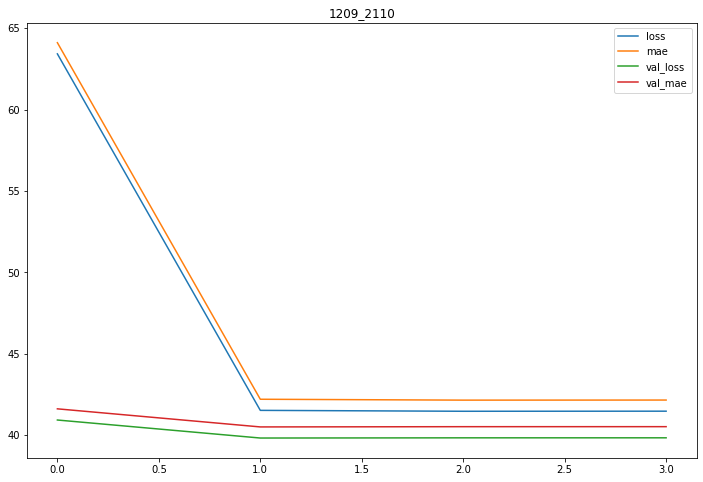

In [ ]:
## 100 users. ##HL  
latency = 'HL'
window_length = 40
shift = 1
batch_size = 32
train_uni_ds = keycodeTotime_prep(train_uni_df, latency, window_length, shift, batch_size)
dev_uni_ds = keycodeTotime_prep(dev_uni_df, latency, window_length, shift, batch_size)
test_uni_ds = keycodeTotime_prep(test_uni_df, latency, window_length, shift, batch_size)

for a, b in train_uni_ds.take(1):
    print(a.shape, b.shape)
    features_dim = a.shape[-1]
    output_dim = 1

train_id = '1209_2110'
model_keyTotime_HL = myModel.create_model_keyTOtime(features_dim, output_dim)
model_name = 'Keycode_TO_Time'

model_keyTotime_HL.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.LogCosh(),
              metrics=['mae'])

# lr_scheduler = prep.create_lr_scheduler(0.01)
EPOCHS = 30
callbacks = prep.get_callbacks(model_name, 2, False)
# callbacks = callbacks + [lr_scheduler]

start_time = time.time()
history_keyTotime_HL = model_keyTotime_HL.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_HL.history).plot(figsize=(12,8), title=train_id);
if 'lr' in list(history_keyTotime_HL.history.keys()):
    print("\n\nreach lr\n\n")
    prep.lr_vs_loss(history_keyTotime_HL);

In [ ]:
model_keyTotime_HL.predict(test_uni_ds)

342/342 [==============================] - 6s 17ms/step


array([[[104.70629],
        [104.72949],
        [104.72949],
        ...,
        [104.72949],
        [104.72949],
        [104.72949]],

       [[104.72066],
        [104.72949],
        [104.72949],
        ...,
        [104.72949],
        [104.72949],
        [104.72949]],

       [[104.72261],
        [104.72949],
        [104.72949],
        ...,
        [104.72949],
        [104.72949],
        [104.72949]],

       ...,

       [[104.72467],
        [104.72949],
        [104.72949],
        ...,
        [104.72949],
        [104.72949],
        [104.72949]],

       [[104.72339],
        [104.72949],
        [104.72949],
        ...,
        [104.72949],
        [104.72949],
        [104.72949]],

       [[104.72568],
        [104.72949],
        [104.72949],
        ...,
        [104.72949],
        [104.72949],
        [104.72949]]], dtype=float32)

In [ ]:
def keycodeTotime_prep_CNN(uni_df, latency, window_length, shift, batch_size):
    df = np.concatenate([KEYCODE_enc.transform(uni_df[['KEYCODE']]).toarray(), uni_df[['INDEX', latency]]], axis=1)
    ds = tf.data.Dataset.from_tensor_slices(df).window(size=window_length, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_length)).batch(batch_size)
    ds = ds.map(lambda windows: (windows[:, :, :-1], windows[:, :, -1]))
    ds = ds.map(lambda input, output: (tf.expand_dims(input, axis=-1), output))
    return ds

In [ ]:
#500 users ##HL 
latency = 'HL'
window_length = 25        ## seems like an important influence!
shift = 1
batch_size = 128
train_uni_ds = keycodeTotime_prep_CNN(train_uni_df, latency, window_length, shift, batch_size)
dev_uni_ds = keycodeTotime_prep_CNN(dev_uni_df, latency, window_length, shift, batch_size)
test_uni_ds = keycodeTotime_prep_CNN(test_uni_df, latency, window_length, shift, batch_size)

for a, b in train_uni_ds.take(1):
    print(a.shape, b.shape)
    features_dim = a.shape[-2]
    output_dim = 1


train_id = '1209_2128'
model_keyTotime_HL_1 = keras.models.Sequential([
        keras.layers.Conv2D(32, (2, features_dim), input_shape=[window_length, features_dim, 1], activation='relu'),
        keras.layers.Dense(output_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.001))])

model_keyTotime_HL_1.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.LogCosh(),
              metrics=['mae'])
EPOCHS = 30
callbacks = prep.get_callbacks(model_name, 2, False)
start_time = time.time()
history_keyTotime_HL_1 = model_keyTotime_HL_1.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_HL_1.history).plot(figsize=(12,8), title=train_id);
# prep.lr_vs_loss(history_keyTotime_HL_1)

(128, 25, 91, 1) (128, 25)
Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221209-223419
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221209-223419
Epoch 1/30
1970/1970 [==============================] - 149s 75ms/step - loss: 70.7934 - mae: 71.4707 - val_loss: 62.6927 - val_mae: 63.3717
Epoch 2/30
1970/1970 [==============================] - 149s 76ms/step - loss: 57.2749 - mae: 57.9491 - val_loss: 51.0214 - val_mae: 51.6953
Epoch 3/30
1970/1970 [==============================] - 148s 75ms/step - loss: 45.0408 - mae: 45.7095 - val_loss: 42.0784 - val_mae: 42.7468
Epoch 4/30
1970/1970 [==============================] - 148s 75ms/step - loss: 40.8829 - mae: 41.5490 - val_loss: 41.0991 - val_mae: 41.7670
Epoch 5/30
1970/1970 [==============================] - 146s 74ms/step - loss: 40.5050 - mae: 41.1707 - val_loss: 40.9703 - val_mae: 41.6385
Epoch 6/30
1970/1970 [======

Time Elapsed During Training (in ms): 5275.3314344882965


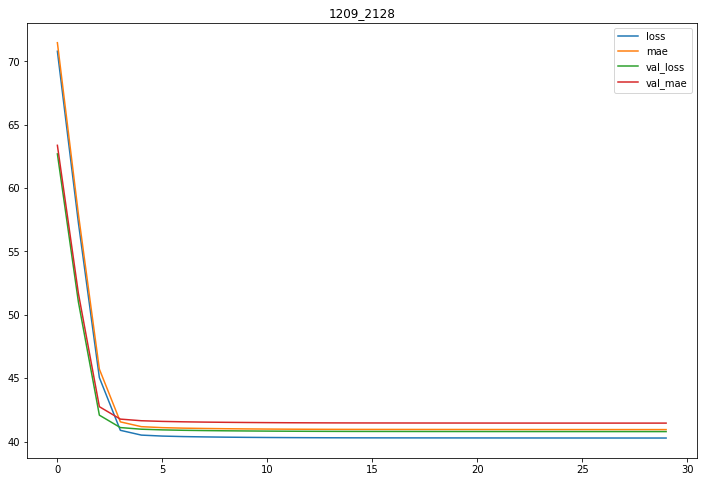

In [ ]:
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_HL_1.history).plot(figsize=(12,8), title=train_id);

In [ ]:
model_keyTotime_HL_1.predict(test_uni_ds)

425/425 [==============================] - 10s 21ms/step


array([[91.44112 ],
       [91.440994],
       [91.4409  ],
       ...,
       [91.44052 ],
       [91.44054 ],
       [91.44054 ]], dtype=float32)

In [ ]:
train_extractor.unigraph.describe()

,INDEX,HL,IL,RL,PL
count,252114.0,252114.0,252114.0,252114.0,252114.0
mean,26.8,118.9,161.5,272.7,280.4
std,19.4,263.8,372.1,384.7,375.3
min,0.0,-6325.0,-24542.0,-23358.0,0.0
25%,11.0,80.0,16.0,124.0,131.0
50%,23.0,103.0,85.0,190.0,189.0
75%,39.0,131.0,188.0,303.0,304.0
max,163.0,44252.0,33832.0,33920.0,38780.0


In [ ]:
train_uni_df

,USER,KEYCODE,INDEX,HL,IL,RL,PL
0,5,16,0.0,168.0,-59.0,0.0,109.0
1,5,84,1.0,59.0,78.0,150.0,137.0
2,5,72,2.0,72.0,0.0,81.0,72.0
3,5,69,3.0,81.0,63.0,147.0,144.0
4,5,32,4.0,84.0,100.0,218.0,184.0
...,...,...,...,...,...,...,...
257563,1641,8,6.0,156.0,140.0,234.0,296.0
257564,1641,8,7.0,94.0,780.0,858.0,874.0
257565,1641,76,8.0,78.0,125.0,203.0,203.0
257566,1641,76,9.0,78.0,171.0,265.0,249.0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257569 entries, 0 to 257568
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   PARTICIPANT_ID   257569 non-null  object
 1   TEST_SECTION_ID  257569 non-null  object
 2   SENTENCE         257569 non-null  object
 3   USER_INPUT       257569 non-null  object
 4   KEYSTROKE_ID     257569 non-null  object
 5   PRESS_TIME       257569 non-null  object
 6   RELEASE_TIME     257569 non-null  object
 7   LETTER           257569 non-null  object
 8   KEYCODE          257569 non-null  object
 9   INDEX            257569 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 19.7+ MB


## Average Users -- Keycode To Time

In [ ]:
avg_mode = 'median'
train_uni_df_avg = train_extractor.unigraph_avg(avg_mode)
dev_uni_df_avg = dev_extractor.unigraph_avg(avg_mode)
test_uni_df_avg = test_extractor.unigraph_avg(avg_mode)

In [ ]:
train_uni_df_avg['HL'].unique()

array([271.,  98.,  93., 108., 102.,  99., 105., 114., 128.,  95.,  91.,
        89., 116.,  92.,  96.,  80., 101., 112.,  82.,  97., 113., 103.,
        90.,  78., 109., 106.,  79.,  88., 104., 120.,  84.,  73.,  77.,
        83.,   0.,  72., 343., 223., 155.,  76.,  71.,  86.,  68.,  48.,
       189.,  64.,  58., 133.])

(128, 25, 91, 1) (128, 25)
Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221210-082834
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221210-082834
Epoch 1/30
1970/1970 [==============================] - 141s 71ms/step - loss: 53.9468 - mae: 54.6261 - val_loss: 43.4977 - val_mae: 44.1747
Epoch 2/30
1970/1970 [==============================] - 137s 70ms/step - loss: 29.0855 - mae: 29.7518 - val_loss: 14.5275 - val_mae: 15.1710
Epoch 3/30
1970/1970 [==============================] - 138s 70ms/step - loss: 13.5437 - mae: 14.1795 - val_loss: 13.7083 - val_mae: 14.3605
Epoch 4/30
1970/1970 [==============================] - 139s 71ms/step - loss: 13.2517 - mae: 13.8897 - val_loss: 13.5490 - val_mae: 14.2014
Epoch 5/30
1970/1970 [==============================] - 139s 70ms/step - loss: 13.1498 - mae: 13.7895 - val_loss: 13.4546 - val_mae: 14.1079
Epoch 6/30
1970/1970 [======

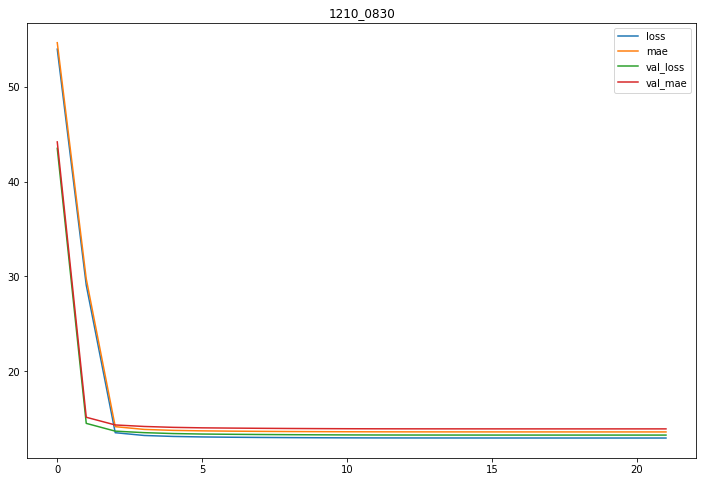

In [ ]:
#500 users ##HL  ## AVG ##CNN
latency = 'HL'
window_length = 25        ## seems like an important influence!
shift = 1
batch_size = 128
train_uni_ds = keycodeTotime_prep_CNN(train_uni_df_avg, latency, window_length, shift, batch_size)
dev_uni_ds = keycodeTotime_prep_CNN(dev_uni_df_avg, latency, window_length, shift, batch_size)
test_uni_ds = keycodeTotime_prep_CNN(test_uni_df_avg, latency, window_length, shift, batch_size)

for a, b in train_uni_ds.take(1):
    print(a.shape, b.shape)
    features_dim = a.shape[-2]
    output_dim = 1

train_id = '1210_0830'
model_keyTotime_HL_1 = keras.models.Sequential([
        keras.layers.Conv2D(32, (2, features_dim), input_shape=[window_length, features_dim, 1], activation='relu'),
        keras.layers.Dense(output_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.001))])

model_keyTotime_HL_1.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss=tf.keras.losses.LogCosh(),
              metrics=['mae'])
EPOCHS = 30
callbacks = prep.get_callbacks(model_name, 2, False)
start_time = time.time()
history_keyTotime_HL_1 = model_keyTotime_HL_1.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_HL_1.history).plot(figsize=(12,8), title=train_id);
# prep.lr_vs_loss(history_keyTotime_HL_1)

In [ ]:
model_keyTotime_HL_1.evaluate(test_uni_ds)

425/425 [==============================] - 20s 46ms/step - loss: 12.5309 - mae: 13.1609


[12.530922889709473, 13.160898208618164]

In [ ]:
model_keyTotime_HL_1.predict(test_uni_ds)

425/425 [==============================] - 5s 12ms/step


array([[[[100.45898 ]],

        [[100.52223 ]],

        [[100.47998 ]],

        ...,

        [[ 99.53798 ]],

        [[ 99.47188 ]],

        [[ 99.42928 ]]],


       [[[100.52223 ]],

        [[100.47998 ]],

        [[100.067505]],

        ...,

        [[ 99.47188 ]],

        [[ 99.42928 ]],

        [[ 99.432144]]],


       [[[100.47998 ]],

        [[100.067505]],

        [[ 99.86447 ]],

        ...,

        [[ 99.42928 ]],

        [[ 99.432144]],

        [[ 99.25725 ]]],


       ...,


       [[[ 98.98988 ]],

        [[ 99.301346]],

        [[ 99.3118  ]],

        ...,

        [[ 98.14405 ]],

        [[ 98.13548 ]],

        [[ 98.344406]]],


       [[[ 99.301346]],

        [[ 99.3118  ]],

        [[ 99.222015]],

        ...,

        [[ 98.13548 ]],

        [[ 98.344406]],

        [[ 98.271545]]],


       [[[ 99.3118  ]],

        [[ 99.222015]],

        [[ 99.14525 ]],

        ...,

        [[ 98.344406]],

        [[ 98.271545]],

        [[ 98.052

In [ ]:
def keycodeTotime_prep(uni_df, latency, window_length, shift, batch_size):
    df = np.concatenate([KEYCODE_enc.transform(uni_df[['KEYCODE']]).toarray(), uni_df[['INDEX', latency]]], axis=1)
    ds = tf.data.Dataset.from_tensor_slices(df).window(size=window_length, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_length)).batch(batch_size)
    ds = ds.map(lambda windows: (windows[:, :, :-1], windows[:, :, -1]))
    return ds

(32, 31, 91) (32, 31)
91 1
Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221210-095707
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221210-095707
Epoch 1/20
7878/7878 [==============================] - 689s 87ms/step - loss: 11.7470 - mae: 11.7470 - val_loss: 6.3905 - val_mae: 6.3905
Epoch 2/20
7878/7878 [==============================] - 654s 83ms/step - loss: 5.0795 - mae: 5.0795 - val_loss: 6.4039 - val_mae: 6.4039
Epoch 3/20
7878/7878 [==============================] - 656s 83ms/step - loss: 4.9543 - mae: 4.9543 - val_loss: 6.2175 - val_mae: 6.2175
Epoch 4/20
7878/7878 [==============================] - 652s 83ms/step - loss: 4.7596 - mae: 4.7596 - val_loss: 6.0688 - val_mae: 6.0688
Epoch 5/20
7878/7878 [==============================] - 653s 83ms/step - loss: 4.6194 - mae: 4.6194 - val_loss: 5.9546 - val_mae: 5.9546
Epoch 6/20
7878/7878 [========================

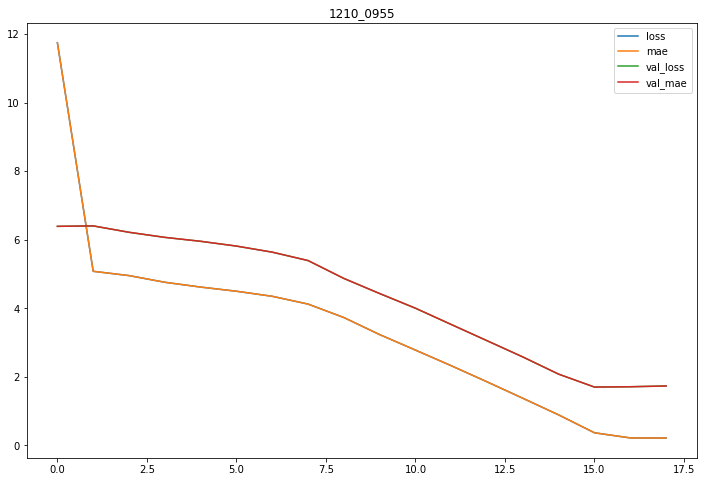

In [ ]:
#500 users ##HL  ## AVG   ##RNN
latency = 'HL'
window_length = 31        ## seems like an important influence!
shift = 1
batch_size = 32
train_uni_ds = keycodeTotime_prep(train_uni_df_avg, latency, window_length, shift, batch_size)
dev_uni_ds = keycodeTotime_prep(dev_uni_df_avg, latency, window_length, shift, batch_size)
test_uni_ds = keycodeTotime_prep(test_uni_df_avg, latency, window_length, shift, batch_size)

for a, b in train_uni_ds.take(1):
    print(a.shape, b.shape)
    features_dim = a.shape[-1]
    output_dim = 1
    print(features_dim, output_dim)

train_id = '1210_0955'
model_keyTotime_HL = myModel.create_model_keyTOtime(features_dim, output_dim)
model_name = 'Keycode_TO_Time'

model_keyTotime_HL.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])
EPOCHS = 20
callbacks = prep.get_callbacks(model_name, 2, False)
start_time = time.time()
history_keyTotime_HL = model_keyTotime_HL.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_HL.history).plot(figsize=(12,8), title=train_id);

In [ ]:
model_keyTotime_HL.evaluate(test_uni_ds)

1697/1697 [==============================] - 26s 15ms/step - loss: 1.5764 - mae: 1.5764


[1.5764259099960327, 1.5764259099960327]

In [ ]:
model_keyTotime_HL.predict(test_uni_ds)

1697/1697 [==============================] - 25s 14ms/step


array([[[ 88.971664],
        [107.98326 ],
        [101.98661 ],
        ...,
        [ 98.799545],
        [101.98674 ],
        [ 98.0084  ]],

       [[107.98761 ],
        [101.98648 ],
        [107.982895],
        ...,
        [101.98677 ],
        [ 98.00841 ],
        [ 92.81625 ]],

       [[101.99779 ],
        [107.98251 ],
        [ 80.015   ],
        ...,
        [ 98.00841 ],
        [ 92.81593 ],
        [ 98.80347 ]],

       ...,

       [[127.98744 ],
        [102.98784 ],
        [107.983826],
        ...,
        [ 96.849594],
        [ 98.00825 ],
        [127.98343 ]],

       [[103.7464  ],
        [107.98381 ],
        [101.986786],
        ...,
        [ 98.00825 ],
        [127.98343 ],
        [ 96.010895]],

       [[107.97862 ],
        [101.9867  ],
        [ 98.823135],
        ...,
        [127.98343 ],
        [ 96.01089 ],
        [ 90.57141 ]]], dtype=float32)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 91), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

(32, 31, 91) (32, 31)
91 1
Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221210-132630
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221210-132630
Epoch 1/20
7878/7878 [==============================] - 658s 83ms/step - loss: 26.3797 - mae: 26.3797 - val_loss: 3.7049 - val_mae: 3.7049
Epoch 2/20
7878/7878 [==============================] - 661s 84ms/step - loss: 1.3319 - mae: 1.3319 - val_loss: 3.6764 - val_mae: 3.6764
Epoch 3/20
7878/7878 [==============================] - 661s 84ms/step - loss: 1.2168 - mae: 1.2168 - val_loss: 3.6676 - val_mae: 3.6676
Epoch 4/20
7878/7878 [==============================] - 659s 84ms/step - loss: 1.1744 - mae: 1.1744 - val_loss: 3.6644 - val_mae: 3.6644
Epoch 5/20
7878/7878 [==============================] - 656s 83ms/step - loss: 1.1499 - mae: 1.1499 - val_loss: 3.6703 - val_mae: 3.6703
Epoch 6/20
7878/7878 [========================

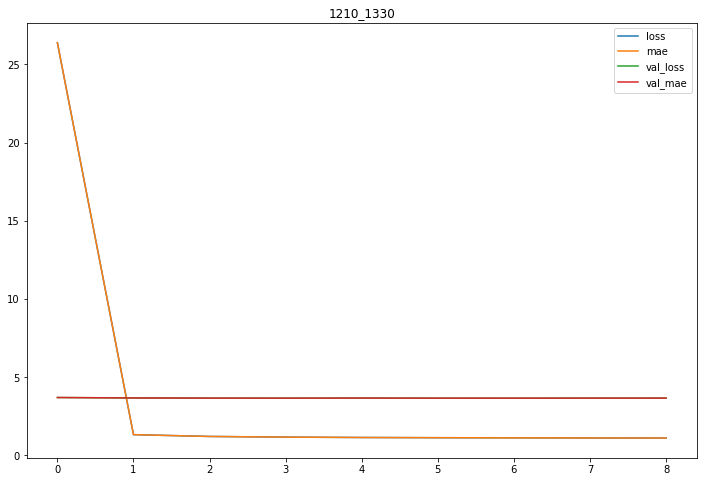

In [ ]:
#500 users ##PL  ## AVG   ##RNN
latency = 'PL'
window_length = 31        ## seems like an important influence!
shift = 1
batch_size = 32
train_uni_ds = keycodeTotime_prep(train_uni_df_avg, latency, window_length, shift, batch_size)
dev_uni_ds = keycodeTotime_prep(dev_uni_df_avg, latency, window_length, shift, batch_size)
test_uni_ds = keycodeTotime_prep(test_uni_df_avg, latency, window_length, shift, batch_size)

for a, b in train_uni_ds.take(1):
    print(a.shape, b.shape)
    features_dim = a.shape[-1]
    output_dim = 1
    print(features_dim, output_dim)

train_id = '1210_1330'
model_keyTotime_PL = myModel.create_model_keyTOtime(features_dim, output_dim)
model_name = 'Keycode_TO_Time'

model_keyTotime_PL.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])
EPOCHS = 20
callbacks = prep.get_callbacks(model_name, 2, False)
start_time = time.time()
history_keyTotime_PL = model_keyTotime_PL.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(history_keyTotime_PL.history).plot(figsize=(12,8), title=train_id);

In [ ]:
model_keyTotime_PL.evaluate(test_uni_ds)

1697/1697 [==============================] - 25s 15ms/step - loss: 4.7994 - mae: 4.7994


[4.79937219619751, 4.79937219619751]

In [ ]:
model_keyTotime_PL.predict(test_uni_ds)

1697/1697 [==============================] - 26s 15ms/step


array([[[175.00209],
        [176.05016],
        [268.99103],
        ...,
        [182.01584],
        [268.99103],
        [160.01427]],

       [[176.05219],
        [268.99103],
        [184.01732],
        ...,
        [268.99103],
        [160.01427],
        [146.02658]],

       [[268.99033],
        [184.0173 ],
        [179.01527],
        ...,
        [160.01427],
        [146.0265 ],
        [182.01573]],

       ...,

       [[183.99893],
        [168.0626 ],
        [184.01726],
        ...,
        [176.0616 ],
        [197.04623],
        [184.0173 ]],

       [[167.9878 ],
        [184.01726],
        [268.99103],
        ...,
        [197.04591],
        [184.0173 ],
        [183.01747]],

       [[184.00543],
        [268.99103],
        [182.01582],
        ...,
        [184.01729],
        [183.01747],
        [200.00795]]], dtype=float32)

In [ ]:
def keycodeTotime_prep_HLPL(uni_df, window_length, shift, batch_size):
    df = np.concatenate([KEYCODE_enc.transform(uni_df[['KEYCODE']]).toarray(), uni_df[['INDEX', 'HL', 'PL']]], axis=1)
    ds = tf.data.Dataset.from_tensor_slices(df).window(size=window_length, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_length)).batch(batch_size)
    ds = ds.map(lambda windows: (windows[:, :, :-2], windows[:, :, -2:]))
    return ds

(32, 31, 91) (32, 31, 2)
91 2
Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/Keycode_TO_Time/20221210-151255
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Keycode_TO_Time/20221210-151255
Epoch 1/20
7878/7878 [==============================] - 658s 83ms/step - loss: 20.6772 - mae: 20.6772 - val_loss: 5.1049 - val_mae: 5.1049
Epoch 2/20
7878/7878 [==============================] - 659s 84ms/step - loss: 3.2984 - mae: 3.2984 - val_loss: 4.8173 - val_mae: 4.8173
Epoch 3/20
7878/7878 [==============================] - 654s 83ms/step - loss: 2.8219 - mae: 2.8219 - val_loss: 4.4521 - val_mae: 4.4521
Epoch 4/20
7878/7878 [==============================] - 659s 84ms/step - loss: 2.4123 - mae: 2.4123 - val_loss: 4.0842 - val_mae: 4.0842
Epoch 5/20
7878/7878 [==============================] - 662s 84ms/step - loss: 1.9548 - mae: 1.9548 - val_loss: 3.6306 - val_mae: 3.6306
Epoch 6/20
7878/7878 [=====================

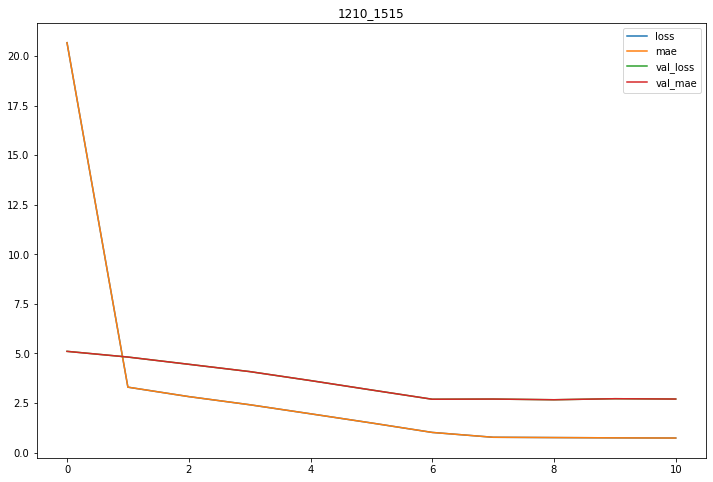

In [ ]:
#500 users ##HL&&&PL  ## AVG   ##RNN
window_length = 31        ## seems like an important influence!
shift = 1
batch_size = 32
train_uni_ds = keycodeTotime_prep_HLPL(train_uni_df_avg, window_length, shift, batch_size)
dev_uni_ds = keycodeTotime_prep_HLPL(dev_uni_df_avg, window_length, shift, batch_size)
test_uni_ds = keycodeTotime_prep_HLPL(test_uni_df_avg, window_length, shift, batch_size)

for a, b in train_uni_ds.take(1):
    print(a.shape, b.shape)
    features_dim = a.shape[-1]
    output_dim = b.shape[-1]
    print(features_dim, output_dim)

train_id = '1210_1515'
model_keyTotime_HLPL = myModel.create_model_keyTOtime(features_dim, output_dim)
model_name = 'Keycode_TO_Time'

model_keyTotime_HLPL.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])
EPOCHS = 20
callbacks = prep.get_callbacks(model_name, 2, False)
start_time = time.time()
model_keyTotime_HLPL = model_keyTotime_HLPL.fit(train_uni_ds, epochs=EPOCHS, validation_data=dev_uni_ds, callbacks=callbacks)
end_time = time.time()
print(f"Time Elapsed During Training (in ms): {end_time - start_time}")
pd.DataFrame(model_keyTotime_HLPL.history).plot(figsize=(12,8), title=train_id);

## Trying original model (multi user, only predict either HL or PL)

In [ ]:
###HL

## prep_main
folder_path = "/content/drive/MyDrive/COMP576/keystroke-samples"      ## up to USER=7001 (inclusive)
sample_size = 400
train_size = 0.7
dev_size = 0.15
data, train_data, dev_data, test_data, KEYCODE_enc, K1_K2_enc, K1_enc, K2_enc, train_extractor, dev_extractor, test_extractor = prep_main(folder_path, sample_size, train_size, dev_size)

## prep_feature_df
graph_mode = 'digraph'
avg_mode = None
encode_keyboard = True
### 'ABS', 'IQR'
filter = 'ABS'
### uni == {'HL':[], 'PL':[], 'IL':[], 'RL':[]}
### di == {'HL1':[], 'HL2':[], 'PL':[], 'IL':[], 'RL':[]}
bounds_dict = {'HL1':[3, 3], 'HL2':[3, 3], 'PL':[0, 10], 'IL':[3, 3], 'RL':[3, 3]}
train_df, dev_df, test_df = prep_feature_df(train_extractor, dev_extractor, test_extractor,
                                            graph_mode, avg_mode, encode_keyboard, filter, bounds_dict)

## prep_tfds
### 'KDS', 'KDI'
input_format = 'KDI'
n_steps = 31
shift = 1
batch_size = 32
### [KEYCODE_enc], [K1_K2_enc], [K1_enc, K2_enc], None
encoders = None


# if graph_mode == 'unigraph':
#     output_features = ['HL', 'PL']
# else:
#     output_features = ['HL2', 'PL']
if graph_mode == 'unigraph':
    output_features = ['HL']
else:
    output_features = ['HL2']


### ['KEYCODE'], ['K1_K2'], ['K1', 'K2']
enc_names = ['K1_K2']
nonkeycodeB_features = ['I1', 'I2', 'HL1']
### True(default), False
# do_onehot = True
mat_length = 40
inputA_features = ['I1', 'HD', 'KD', 'IL', 'RL', 'PL', 'HL']
inputB_features = ['I1', 'HD', 'KD']
### 'image'(default), 'one-hot', 'label'
# inputB_type = 'image'
### True, False(default)
# keep_smaller_window = False
### True(default), False
# add_UNK = True
trainset, devset, testset, train_KD, test_KD = prep_tfds(train_data, input_format, train_df, dev_df, test_df,
                                                         n_steps, shift, batch_size, encoders, output_features,
                                                         enc_names, nonkeycodeB_features, graph_mode,
                                                         mat_length, inputA_features, inputB_features)

## Pretraining CHECKS!!!!!
if input_format == 'KDS':
    input_features = [nonkeycodeB_features]
else:
    input_features = [inputA_features, inputB_features]
pretraining_check(data, train_data, dev_data, test_data,
                  train_df, 
                  encoders, enc_names, input_format, graph_mode,
                  input_features, output_features, train_KD)

In total 400 users in the total_data dataset, with 294546 keystroke samples
In total 400 users in the train_data dataset, with 205986 keystroke samples
In total 400 users in the dev_data dataset, with 43981 keystroke samples
In total 400 users in the test_data dataset, with 44579 keystroke samples


train_df.head(1): 
   USER  K1  K2  I1  I2  KD  HD   HL1  HL2    IL  RL    PL
0    5  16  84 0.0 1.0   5 3.0 168.0 59.0 -59.0 0.0 109.0
train_df.describe: 
             I1       I2       KD       HD      HL1      HL2       IL       RL  \
count 188782.0 188782.0 188782.0 188782.0 188782.0 188782.0 188782.0 188782.0   
mean      26.9     27.9      3.4      2.2    109.9    107.5    140.0    247.5   
std       19.3     19.3      1.5      0.8     48.2     41.4    205.7    207.7   
min        0.0      1.0      0.0      0.0      0.0      1.0   -285.0   -122.0   
25%       11.0     12.0      2.0      1.5     80.0     80.0     21.0    128.0   
50%       24.0     25.0      4.0      2.0    101.0    10

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI_LeNet5_Dense-64-2-Reg/20221211-075928
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI_LeNet5_Dense-64-2-Reg/20221211-075928
Epoch 1/20
5500/5500 [==============================] - 42s 7ms/step - loss: 33.0414 - mae: 31.8347 - val_loss: 43.5567 - val_mae: 42.9660
Epoch 2/20
5500/5500 [==============================] - 39s 7ms/step - loss: 26.6856 - mae: 26.5643 - val_loss: 21.5222 - val_mae: 21.5076
Epoch 3/20
5500/5500 [==============================] - 38s 7ms/step - loss: 23.4810 - mae: 23.5435 - val_loss: 20.7734 - val_mae: 20.8497
Epoch 4/20
5500/5500 [==============================] - 38s 7ms/step - loss: 22.8084 - mae: 22.9333 - val_loss: 20.5592 - val_mae: 20.6805
Epoch 5/20
5500/5500 [==============================] - 38s 7ms/step - loss: 22.4109 - mae: 22.5700 - val_loss: 20.9604 - val_mae: 21.1141
Epoch 6/20
5500/5500 [=======================

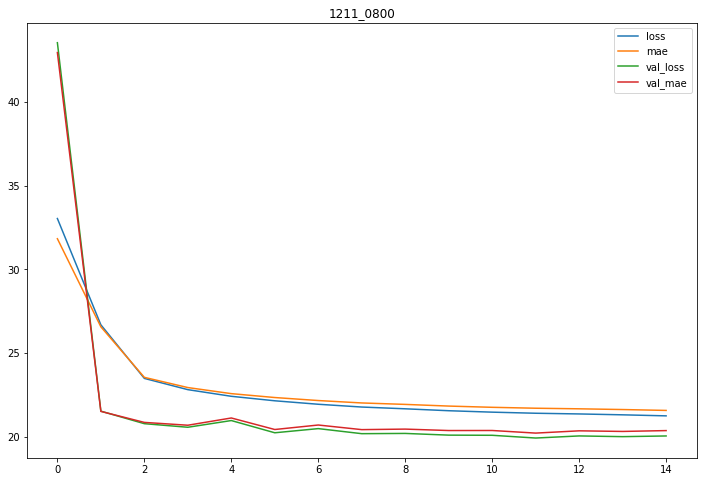

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = 0.001
train_id = '1211_0800'
model_name = 'KDI_LeNet5_Dense-64-2-Reg'
model_structure = myModel.create_model_6
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 3
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

In [ ]:
y_pred = model.predict(testset)

557/557 [==============================] - 2s 4ms/step


Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-32-2/20221211-081804
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-32-2/20221211-081804
Epoch 1/20
5500/5500 [==============================] - 37s 7ms/step - loss: 34.3447 - mae: 31.3742 - val_loss: 36.5763 - val_mae: 33.4551
Epoch 2/20
5500/5500 [==============================] - 36s 7ms/step - loss: 26.5060 - mae: 25.4850 - val_loss: 21.8034 - val_mae: 20.8978
Epoch 3/20
5500/5500 [==============================] - 36s 7ms/step - loss: 23.4717 - mae: 23.0298 - val_loss: 20.8399 - val_mae: 20.4569
Epoch 4/20
5500/5500 [==============================] - 36s 7ms/step - loss: 22.5982 - mae: 22.4543 - val_loss: 21.1594 - val_mae: 20.9841
Epoch 5/20
5500/5500 [==============================] - 36s 6ms/step - loss: 22.0865 - mae: 22.1072 - val_loss: 20.8420 - val_mae: 20.8288
Epoch 6/20
5500/5500 [===========================

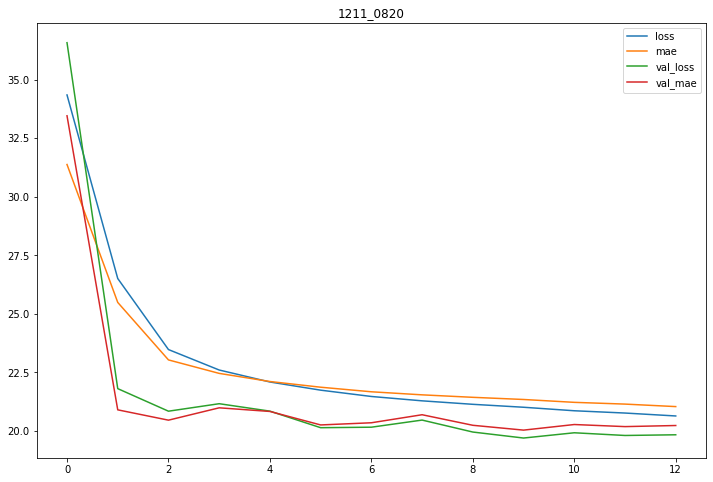

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_0820'
model_name = 'KDI-s_KDI-xs_Dense-32-2'
model_structure = myModel.create_model_3
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.0004
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 3
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI_LeNet5_Dense-64-2-Reg/20221210-182553-avg
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI_LeNet5_Dense-64-2-Reg/20221210-182553-avg
Epoch 1/3
4193/4193 [==============================] - 259s 61ms/step - loss: 7.7478 - mae: 6.5215 - val_loss: 5.4480 - val_mae: 4.5434
Epoch 2/3
4193/4193 [==============================] - 255s 61ms/step - loss: 2.4001 - mae: 1.7088 - val_loss: 5.1649 - val_mae: 4.9407
Epoch 3/3
4193/4193 [==============================] - 254s 61ms/step - loss: 1.5611 - mae: 1.2516 - val_loss: 4.2180 - val_mae: 4.1573
Time Elapsed During Training (in ms): 767.3955233097076
1/1 [==============================] - 0s 235ms/step
The evaluation results are: 
 Loss: 3.846299409866333
 Metrics: [3.7912042140960693]

       HL2
count 32.0
mean   3.9
std    4.6
min    0.0
25%    1.0
50%    3.0
75%    5.0
max   24.0


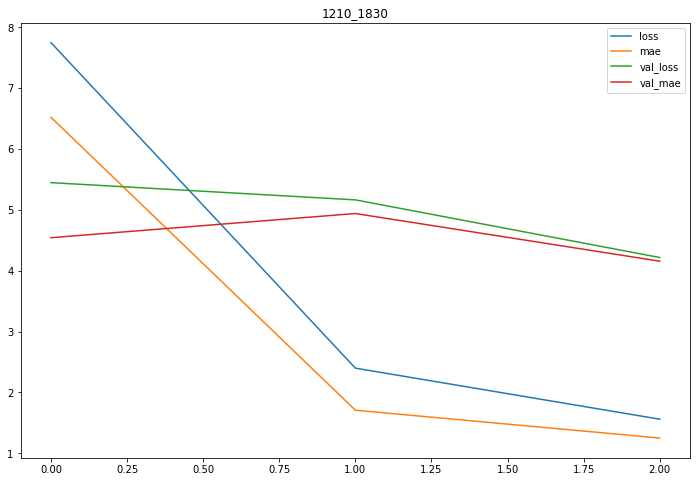

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = 0.001
train_id = '1210_1830'
model_name = 'KDI_LeNet5_Dense-64-2-Reg'
model_structure = myModel.create_model_7
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.0005
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 3
patience = 3
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

In [ ]:
###PPPL ##avg

## prep_main
folder_path = "/content/drive/MyDrive/COMP576/keystroke-samples"      ## up to USER=7001 (inclusive)
sample_size = 400
train_size = 0.7
dev_size = 0.15
data, train_data, dev_data, test_data, KEYCODE_enc, K1_K2_enc, K1_enc, K2_enc, train_extractor, dev_extractor, test_extractor = prep_main(folder_path, sample_size, train_size, dev_size)

## prep_feature_df
graph_mode = 'digraph'
avg_mode = None
encode_keyboard = True
### 'ABS', 'IQR'
filter = 'ABS'
### uni == {'HL':[], 'PL':[], 'IL':[], 'RL':[]}
### di == {'HL1':[], 'HL2':[], 'PL':[], 'IL':[], 'RL':[]}
bounds_dict = {'HL1':[3, 3], 'HL2':[3, 3], 'PL':[0, 10], 'IL':[3, 3], 'RL':[3, 3]}
train_df, dev_df, test_df = prep_feature_df(train_extractor, dev_extractor, test_extractor,
                                            graph_mode, avg_mode, encode_keyboard, filter, bounds_dict)

## prep_tfds
### 'KDS', 'KDI'
input_format = 'KDI'
n_steps = 31
shift = 1
batch_size = 32
### [KEYCODE_enc], [K1_K2_enc], [K1_enc, K2_enc], None
encoders = None


# if graph_mode == 'unigraph':
#     output_features = ['HL', 'PL']
# else:
#     output_features = ['HL2', 'PL']
# if graph_mode == 'unigraph':
#     output_features = ['HL']
# else:
#     output_features = ['HL2']
output_features = ['PL']


### ['KEYCODE'], ['K1_K2'], ['K1', 'K2']
enc_names = ['K1_K2']
nonkeycodeB_features = ['I1', 'I2', 'HL1']
### True(default), False
# do_onehot = True
mat_length = 40
inputA_features = ['I1', 'HD', 'KD', 'IL', 'RL', 'PL', 'HL']
inputB_features = ['I1', 'HD', 'KD']
### 'image'(default), 'one-hot', 'label'
# inputB_type = 'image'
### True, False(default)
# keep_smaller_window = False
### True(default), False
# add_UNK = True
trainset, devset, testset, train_KD, test_KD = prep_tfds(train_data, input_format, train_df, dev_df, test_df,
                                                         n_steps, shift, batch_size, encoders, output_features,
                                                         enc_names, nonkeycodeB_features, graph_mode,
                                                         mat_length, inputA_features, inputB_features)

## Pretraining CHECKS!!!!!
if input_format == 'KDS':
    input_features = [nonkeycodeB_features]
else:
    input_features = [inputA_features, inputB_features]
pretraining_check(data, train_data, dev_data, test_data,
                  train_df, 
                  encoders, enc_names, input_format, graph_mode,
                  input_features, output_features, train_KD)

In total 400 users in the total_data dataset, with 294546 keystroke samples
In total 400 users in the train_data dataset, with 205986 keystroke samples
In total 400 users in the dev_data dataset, with 43981 keystroke samples
In total 400 users in the test_data dataset, with 44579 keystroke samples


train_df.head(1): 
   USER  K1  K2  I1  I2  KD  HD   HL1  HL2    IL  RL    PL
0    5  16  84 0.0 1.0   5 3.0 168.0 59.0 -59.0 0.0 109.0
train_df.describe: 
             I1       I2       KD       HD      HL1      HL2       IL       RL  \
count 188782.0 188782.0 188782.0 188782.0 188782.0 188782.0 188782.0 188782.0   
mean      26.9     27.9      3.4      2.2    109.9    107.5    140.0    247.5   
std       19.3     19.3      1.5      0.8     48.2     41.4    205.7    207.7   
min        0.0      1.0      0.0      0.0      0.0      1.0   -285.0   -122.0   
25%       11.0     12.0      2.0      1.5     80.0     80.0     21.0    128.0   
50%       24.0     25.0      4.0      2.0    101.0    10

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI_LeNet5_Dense-64-2-Reg/20221211-085555
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI_LeNet5_Dense-64-2-Reg/20221211-085555
Epoch 1/20
5500/5500 [==============================] - 49s 7ms/step - loss: 115.3166 - mae: 112.0722 - val_loss: 73.0548 - val_mae: 70.1051 - lr: 7.0000e-05
Epoch 2/20
5500/5500 [==============================] - 38s 7ms/step - loss: 110.7727 - mae: 108.1447 - val_loss: 70.8942 - val_mae: 68.5082 - lr: 1.0000e-04
Epoch 3/20
5500/5500 [==============================] - 39s 7ms/step - loss: 107.6847 - mae: 105.8195 - val_loss: 69.7141 - val_mae: 68.2672 - lr: 4.0000e-04
Epoch 4/20
5500/5500 [==============================] - 38s 7ms/step - loss: 102.9009 - mae: 101.7000 - val_loss: 66.4510 - val_mae: 65.4352 - lr: 7.0000e-04
Epoch 5/20
5500/5500 [==============================] - 38s 7ms/step - loss: 101.1282 - mae: 100.1487 - val_

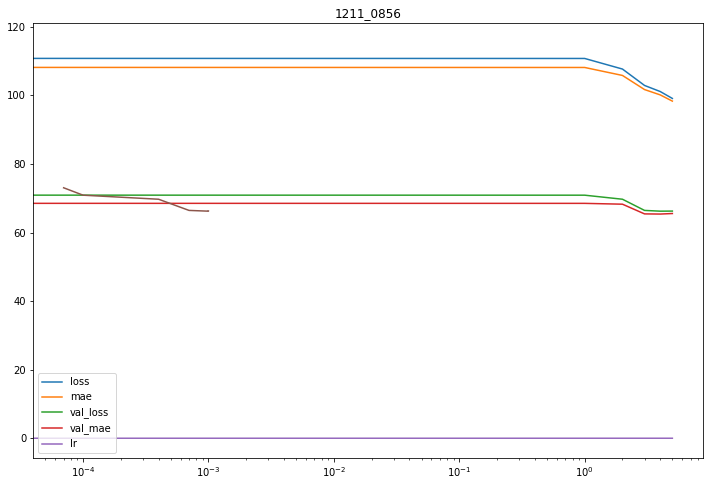

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = 0.001
train_id = '1211_0856'
model_name = 'KDI_LeNet5_Dense-64-2-Reg'
model_structure = myModel.create_model_6
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

# lr = 0.0005
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
lr_scheduler = prep.create_lr_scheduler(0.001)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

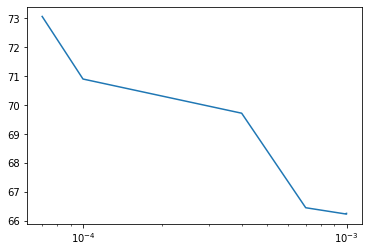

In [ ]:
prep.lr_vs_loss(history)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-32-2/20221211-090453
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-32-2/20221211-090453
Epoch 1/20
5500/5500 [==============================] - 38s 7ms/step - loss: 126.7777 - mae: 113.3560 - val_loss: 77.2513 - val_mae: 68.5051 - lr: 7.0000e-05
Epoch 2/20
5500/5500 [==============================] - 36s 7ms/step - loss: 113.5288 - mae: 106.6683 - val_loss: 71.5196 - val_mae: 66.6369 - lr: 1.0000e-04
Epoch 3/20
5500/5500 [==============================] - 37s 7ms/step - loss: 106.0634 - mae: 102.6357 - val_loss: 65.2261 - val_mae: 63.3085 - lr: 4.0000e-04
Epoch 4/20
5500/5500 [==============================] - 36s 7ms/step - loss: 101.6222 - mae: 99.9827 - val_loss: 63.6719 - val_mae: 62.8669 - lr: 7.0000e-04
Epoch 5/20
5500/5500 [==============================] - 36s 7ms/step - loss: 99.7130 - mae: 98.8738 - val_loss: 6

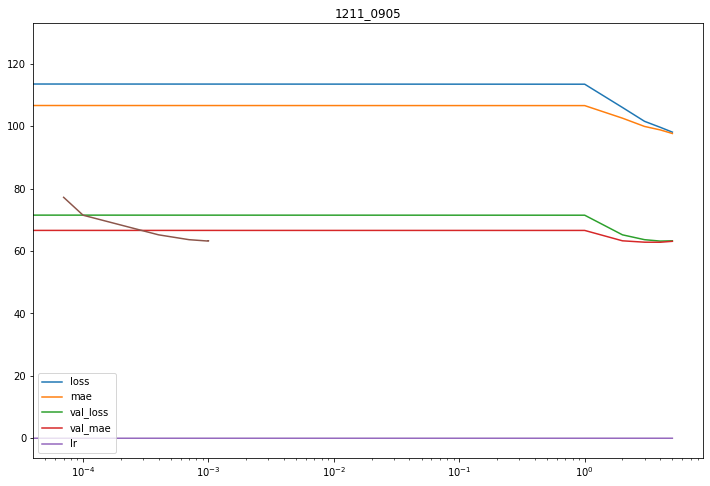

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = 0.001
train_id = '1211_0905'
model_name = 'KDI-s_KDI-xs_Dense-32-2'
model_structure = myModel.create_model_3
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

# lr = 0.0005
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
lr_scheduler = prep.create_lr_scheduler(0.001)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

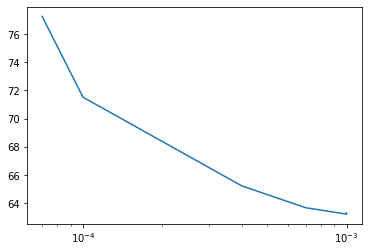

In [ ]:
prep.lr_vs_loss(history)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-32-2/20221211-091537
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-32-2/20221211-091537
Epoch 1/20
5500/5500 [==============================] - 63s 11ms/step - loss: 113.0672 - mae: 107.4304 - val_loss: 68.0606 - val_mae: 65.3607
Epoch 2/20
5500/5500 [==============================] - 60s 11ms/step - loss: 101.8588 - mae: 99.8910 - val_loss: 64.1356 - val_mae: 62.9946
Epoch 3/20
5500/5500 [==============================] - 60s 11ms/step - loss: 99.0254 - mae: 97.9280 - val_loss: 63.3186 - val_mae: 62.6644
Epoch 4/20
5500/5500 [==============================] - 61s 11ms/step - loss: 97.6752 - mae: 96.9817 - val_loss: 62.7394 - val_mae: 62.4164
Epoch 5/20
5500/5500 [==============================] - 57s 10ms/step - loss: 96.8799 - mae: 96.4250 - val_loss: 62.5503 - val_mae: 62.4364
Epoch 6/20
5500/5500 [===================

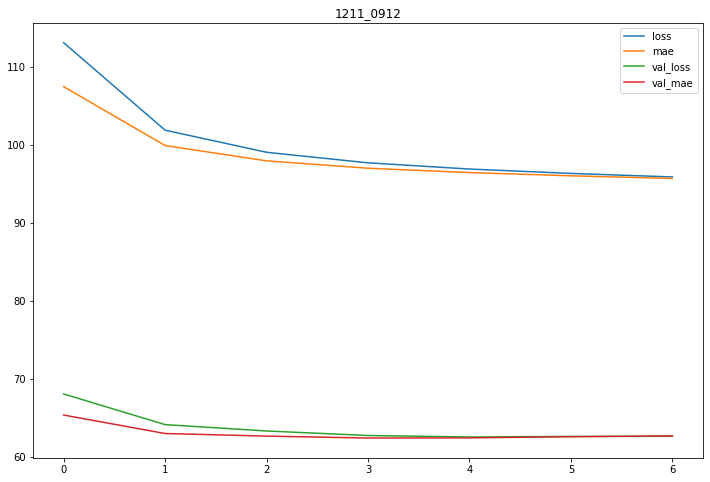

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = 0.001
train_id = '1211_0912'
model_name = 'KDI-s_KDI-xs_Dense-32-2'
model_structure = myModel.create_model_3
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.0006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.001)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 2
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

In [ ]:
def create_model_8(inputA_feature_dim,
                   inputB_feature_dim,
                   output_dim,
                   mat_length,
                   model_name='KDI-s_KDI-xs_Dense-nonReLU'):
    inputA = keras.layers.Input(shape=[mat_length, mat_length, inputA_feature_dim], name='inputA')
    inputB = keras.layers.Input(shape=[mat_length, mat_length, inputB_feature_dim], name='inputB')
    
    user = keras.layers.Conv2D(32, (3, 3), 2, activation='relu')(inputA)
    user = keras.layers.Conv2D(32, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2), activation='relu')(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2), activation='relu')(user)
    user = keras.layers.Flatten()(user)
    user = keras.layers.Dense(64, activation='relu')(user)
    
    keycode = keras.layers.Conv2D(16, (3, 3), 2)(inputB)
    keycode = keras.layers.Conv2D(16, (3, 3))(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3))(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3))(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Flatten()(keycode)
    # keycode = keras.layers.Dense(32, activation='relu')(keycode)

    concat = keras.layers.concatenate([user, keycode])
    concat = keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.L1(0.001))(concat)
    concat = keras.layers.Dense(32)(concat)
    output = keras.layers.Dense(output_dim)(concat)

    model = keras.Model(inputs=[inputA, inputB], outputs=[output])
    return model

def create_model_9(inputA_feature_dim,
                   inputB_feature_dim,
                   output_dim,
                   mat_length,
                   model_name='KDI-s_KDI-xs_Dense-ReLU'):
    inputA = keras.layers.Input(shape=[mat_length, mat_length, inputA_feature_dim], name='inputA')
    inputB = keras.layers.Input(shape=[mat_length, mat_length, inputB_feature_dim], name='inputB')
    
    user = keras.layers.Conv2D(32, (3, 3), 2, activation='relu')(inputA)
    user = keras.layers.Conv2D(32, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Flatten()(user)
    user = keras.layers.Dense(128, activation='relu')(user)
    
    keycode = keras.layers.Conv2D(16, (3, 3), 2, activation='relu')(inputB)
    keycode = keras.layers.Conv2D(16, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Flatten()(keycode)
    keycode = keras.layers.Dense(64, activation='relu')(keycode)

    concat = keras.layers.concatenate([user, keycode])
    concat = keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.L1(0.001), activation='relu')(concat)
    concat = keras.layers.Dense(32)(concat)
    output = keras.layers.Dense(output_dim)(concat)

    model = keras.Model(inputs=[inputA, inputB], outputs=[output])
    return model

def create_model_10(inputA_feature_dim,
                   inputB_feature_dim,
                   output_dim,
                   mat_length,
                   model_name='KDI-s_KDI-xs_Dense-ReLU-l2reg'):
    inputA = keras.layers.Input(shape=[mat_length, mat_length, inputA_feature_dim], name='inputA')
    inputB = keras.layers.Input(shape=[mat_length, mat_length, inputB_feature_dim], name='inputB')
    
    user = keras.layers.Conv2D(32, (3, 3), 2, activation='relu')(inputA)
    user = keras.layers.Conv2D(32, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Flatten()(user)
    user = keras.layers.Dense(128, activation='relu')(user)
    
    keycode = keras.layers.Conv2D(16, (3, 3), 2, activation='relu')(inputB)
    keycode = keras.layers.Conv2D(16, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Flatten()(keycode)
    keycode = keras.layers.Dense(64, activation='relu')(keycode)

    concat = keras.layers.concatenate([user, keycode])
    concat = keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.L2(0.0001), activation='relu')(concat)
    concat = keras.layers.Dense(64, activation='relu')(concat)
    concat = keras.layers.Dense(32)(concat)
    output = keras.layers.Dense(output_dim)(concat)

    model = keras.Model(inputs=[inputA, inputB], outputs=[output])
    return model

def create_model_11(inputA_feature_dim,
                   inputB_feature_dim,
                   output_dim,
                   mat_length,
                   model_name='KDI-s_KDI-xs_Dense-ReLU-l1l2reg'):
    inputA = keras.layers.Input(shape=[mat_length, mat_length, inputA_feature_dim], name='inputA')
    inputB = keras.layers.Input(shape=[mat_length, mat_length, inputB_feature_dim], name='inputB')
    
    user = keras.layers.Conv2D(32, (3, 3), 2, activation='relu')(inputA)
    user = keras.layers.Conv2D(32, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Flatten()(user)
    user = keras.layers.Dense(128, activation='relu')(user)
    
    keycode = keras.layers.Conv2D(16, (3, 3), 2, activation='relu')(inputB)
    keycode = keras.layers.Conv2D(16, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Flatten()(keycode)
    keycode = keras.layers.Dense(64, activation='relu')(keycode)

    concat = keras.layers.concatenate([user, keycode])
    concat = keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.L1L2(0.0001), activation='relu')(concat)
    concat = keras.layers.Dense(64, activation='relu')(concat)
    concat = keras.layers.Dense(32, activation='relu')(concat)
    output = keras.layers.Dense(output_dim, activation='relu')(concat)

    model = keras.Model(inputs=[inputA, inputB], outputs=[output])
    return model

def create_model_12(inputA_feature_dim,
                   inputB_feature_dim,
                   output_dim,
                   mat_length,
                   model_name='KDI-s_KDI-xs_Dense-ReLU-noreg'):
    inputA = keras.layers.Input(shape=[mat_length, mat_length, inputA_feature_dim], name='inputA')
    inputB = keras.layers.Input(shape=[mat_length, mat_length, inputB_feature_dim], name='inputB')
    
    user = keras.layers.Conv2D(32, (3, 3), 2, activation='relu')(inputA)
    user = keras.layers.Conv2D(32, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Flatten()(user)
    user = keras.layers.Dense(128, activation='relu')(user)
    user = keras.layers.Dense(64, activation='relu')(user)
    user = keras.layers.Dense(32, activation='relu')(user)
    
    keycode = keras.layers.Conv2D(16, (3, 3), 2, activation='relu')(inputB)
    keycode = keras.layers.Conv2D(16, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.Conv2D(64, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Flatten()(keycode)
    keycode = keras.layers.Dense(128, activation='relu')(keycode)

    concat = keras.layers.concatenate([user, keycode])
    concat = keras.layers.Dense(80, activation='relu')(concat)
    concat = keras.layers.Dense(40, activation='relu')(concat)
    concat = keras.layers.Dense(20, activation='relu')(concat)
    output = keras.layers.Dense(output_dim, activation='relu')(concat)

    model = keras.Model(inputs=[inputA, inputB], outputs=[output])
    return model

def create_model_13(inputA_feature_dim,
                   inputB_feature_dim,
                   output_dim,
                   mat_length,
                   model_name='KDI-1s_KDI-xs_GRU'):
    inputA = keras.layers.Input(shape=[mat_length, mat_length, inputA_feature_dim], name='inputA')
    inputB = keras.layers.Input(shape=[mat_length, mat_length, inputB_feature_dim], name='inputB')
    
    user = keras.layers.Conv2D(32, (3, 3), 2, activation='relu')(inputA)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Conv2D(64, (3, 3), activation='relu')(user)
    user = keras.layers.MaxPooling2D((2, 2))(user)
    user = keras.layers.Conv2D(128, (3, 3), activation='relu')(user)
    user = keras.layers.Flatten()(user)
    user = keras.layers.Dense(128, activation='relu')(user)
    user = keras.layers.Dense(32, activation='relu')(user)
    user = keras.layers.Dense(8, activation='relu')(user)
    user = tf.repeat(tf.expand_dims(user, axis=1), 49, axis=1)
    
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputB)
    keycode = keras.layers.Conv2D(32, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Conv2D(64, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.Conv2D(64, (3, 3), activation='relu')(keycode)
    keycode = keras.layers.MaxPooling2D((2, 2))(keycode)
    keycode = keras.layers.Reshape((-1, 64))(keycode)

    concat = keras.layers.concatenate([user, keycode])
    concat = keras.layers.GRU(72, return_sequences=True)(concat)
    concat = keras.layers.GRU(72)(concat)
    concat = keras.layers.Dense(32, activation='relu')(concat)
    output = keras.layers.Dense(output_dim, activation='relu')(concat)

    model = keras.Model(inputs=[inputA, inputB], outputs=[output])
    return model

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-nonReLU/20221211-094415
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-nonReLU/20221211-094415
Epoch 1/20
5500/5500 [==============================] - 57s 10ms/step - loss: 109.8884 - mae: 109.3529 - val_loss: 68.6747 - val_mae: 68.4108 - lr: 7.0000e-05
Epoch 2/20
5500/5500 [==============================] - 56s 10ms/step - loss: 105.7712 - mae: 105.5245 - val_loss: 66.5158 - val_mae: 66.4339 - lr: 1.0000e-04
Epoch 3/20
5500/5500 [==============================] - 58s 11ms/step - loss: 104.0256 - mae: 103.8431 - val_loss: 66.3570 - val_mae: 66.2859 - lr: 4.0000e-04
Epoch 4/20
5500/5500 [==============================] - 58s 11ms/step - loss: 102.9961 - mae: 102.7648 - val_loss: 71.2872 - val_mae: 71.0313 - lr: 7.0000e-04
Time Elapsed During Training (in ms): 229.25206446647644


reach lr but cannot plot


1/1 [===========

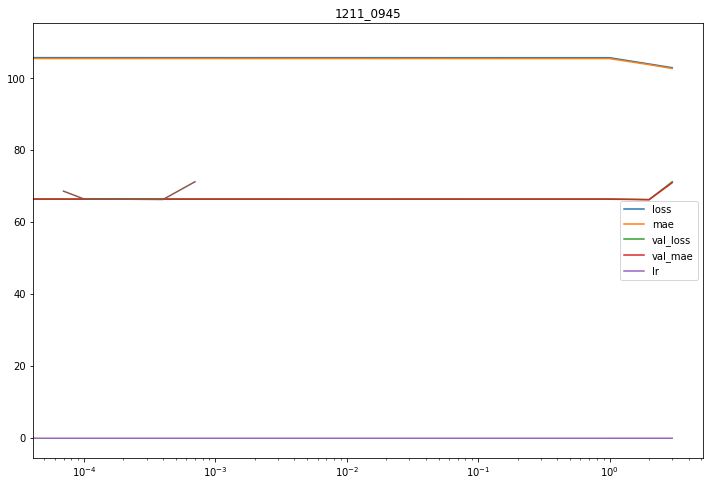

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_0945'
model_name = 'KDI-s_KDI-xs_Dense-nonReLU'
model_structure = create_model_8
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

# lr = 0.0006
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
lr_scheduler = prep.create_lr_scheduler(0.01)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

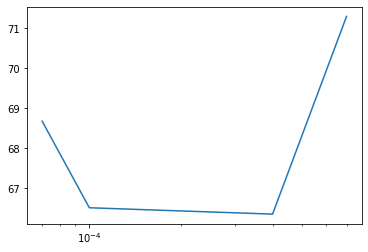

In [ ]:
prep.lr_vs_loss(history)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-ReLU/20221211-095830
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-ReLU/20221211-095830
Epoch 1/20
5500/5500 [==============================] - 58s 10ms/step - loss: 108.7589 - mae: 108.5626 - val_loss: 67.3114 - val_mae: 67.1893 - lr: 7.0000e-05
Epoch 2/20
5500/5500 [==============================] - 57s 10ms/step - loss: 100.4549 - mae: 100.3518 - val_loss: 63.5831 - val_mae: 63.5911 - lr: 1.0000e-04
Epoch 3/20
5500/5500 [==============================] - 60s 11ms/step - loss: 98.2113 - mae: 98.3364 - val_loss: 77.4480 - val_mae: 77.6704 - lr: 4.0000e-04
Time Elapsed During Training (in ms): 174.10190844535828


reach lr but cannot plot


557/557 [==============================] - 5s 9ms/step - loss: 78.4926 - mae: 78.7128


1/1 [==============================] - 0s 141ms/step
The evaluation results are: 
 Loss: 78.49262237548828
 Metrics: [78.71282196044922]

         PL
count  32.0
mean   56.2
std    38.6
min     1.0
25%    27.0
50%    48.0
75%    79.2
max   138.0


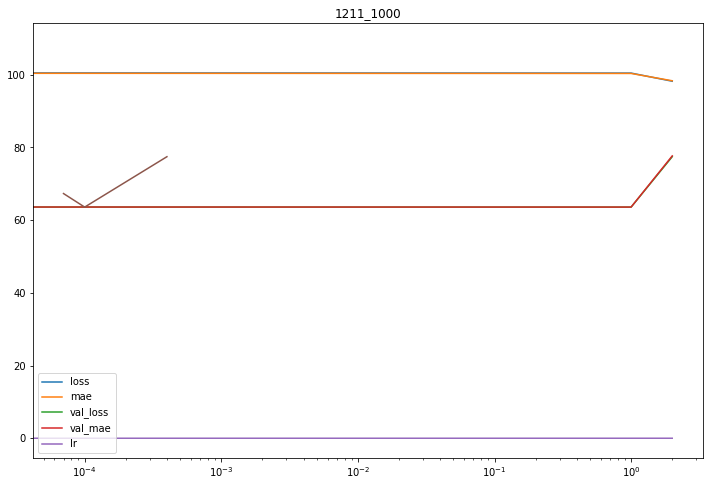

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1000'
model_name = 'KDI-s_KDI-xs_Dense-ReLU'
model_structure = create_model_9
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

# lr = 0.0006
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
lr_scheduler = prep.create_lr_scheduler(0.01)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

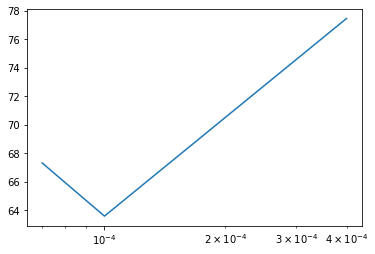

In [ ]:
prep.lr_vs_loss(history)

In [ ]:
# del(model_structure)
# del(optimizer)
# del(lr_scheduler)
# del(loss)
# del(callbacks)
# del(model)
# del(history)
# del(eval_results)
# del(diff)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-ReLU/20221211-100323
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-ReLU/20221211-100323
Epoch 1/20
5500/5500 [==============================] - 62s 11ms/step - loss: 110.1702 - mae: 109.9490 - val_loss: 68.4795 - val_mae: 68.4183
Epoch 2/20
5500/5500 [==============================] - 64s 12ms/step - loss: 102.6412 - mae: 102.5754 - val_loss: 64.0474 - val_mae: 64.0586
Epoch 3/20
5500/5500 [==============================] - 67s 12ms/step - loss: 98.1332 - mae: 98.1305 - val_loss: 62.5280 - val_mae: 62.6414
Epoch 4/20
5500/5500 [==============================] - 64s 12ms/step - loss: 95.3975 - mae: 95.4784 - val_loss: 61.6299 - val_mae: 61.8205
Epoch 5/20
5500/5500 [==============================] - 61s 11ms/step - loss: 93.6099 - mae: 93.7501 - val_loss: 61.3746 - val_mae: 61.6118
Epoch 6/20
5500/5500 [==================

1/1 [==============================] - 0s 141ms/step
The evaluation results are: 
 Loss: 62.263023376464844
 Metrics: [62.62077331542969]

        PL
count 32.0
mean  30.2
std   22.9
min    1.0
25%    8.5
50%   25.5
75%   50.2
max   67.0


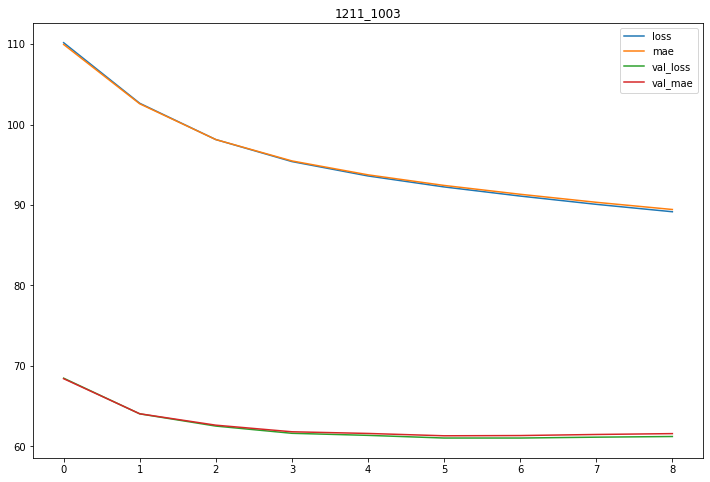

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1003'
model_name = 'KDI-s_KDI-xs_Dense-ReLU'
model_structure = create_model_9
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.00008
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 2
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-ReLU-l2reg/20221211-101530
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-ReLU-l2reg/20221211-101530
Epoch 1/20
5500/5500 [==============================] - 64s 12ms/step - loss: 111.2498 - mae: 109.7332 - val_loss: 69.0567 - val_mae: 68.8787 - lr: 7.0000e-05
Epoch 2/20
5500/5500 [==============================] - 61s 11ms/step - loss: 100.7207 - mae: 100.7280 - val_loss: 67.2824 - val_mae: 67.5126 - lr: 1.0000e-04
Epoch 3/20
5500/5500 [==============================] - 63s 11ms/step - loss: 98.2798 - mae: 98.6717 - val_loss: 73.9554 - val_mae: 74.4790 - lr: 4.0000e-04
Time Elapsed During Training (in ms): 188.13069033622742


reach lr but cannot plot


1/1 [==============================] - 0s 362ms/step
The evaluation results are: 
 Loss: 74.99815368652344
 Metrics: [75.51994323730469]

         PL
count  32.0
mean   51

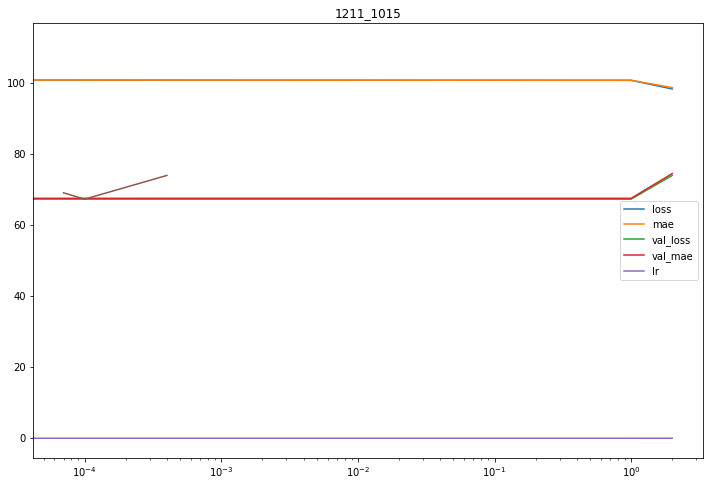

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1015'
model_name = 'KDI-s_KDI-xs_Dense-ReLU-l2reg'
model_structure = create_model_10
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

# lr = 0.0006
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
lr_scheduler = prep.create_lr_scheduler(0.01)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

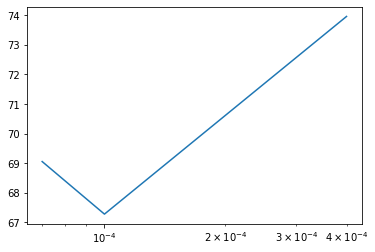

In [ ]:
prep.lr_vs_loss(history)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-ReLU-l2reg/20221211-102030
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-ReLU-l2reg/20221211-102030
Epoch 1/20
5500/5500 [==============================] - 67s 12ms/step - loss: 110.9742 - mae: 109.9515 - val_loss: 68.3301 - val_mae: 68.2580
Epoch 2/20
5500/5500 [==============================] - 67s 12ms/step - loss: 101.2797 - mae: 101.3163 - val_loss: 64.0992 - val_mae: 64.3405
Epoch 3/20
5500/5500 [==============================] - 64s 12ms/step - loss: 96.8114 - mae: 97.0612 - val_loss: 62.0521 - val_mae: 62.4530
Epoch 4/20
5500/5500 [==============================] - 64s 12ms/step - loss: 94.6539 - mae: 95.0148 - val_loss: 61.4459 - val_mae: 61.9234
Epoch 5/20
5500/5500 [==============================] - 63s 11ms/step - loss: 93.0637 - mae: 93.4884 - val_loss: 61.3794 - val_mae: 61.8956
Epoch 6/20
5500/5500 [======

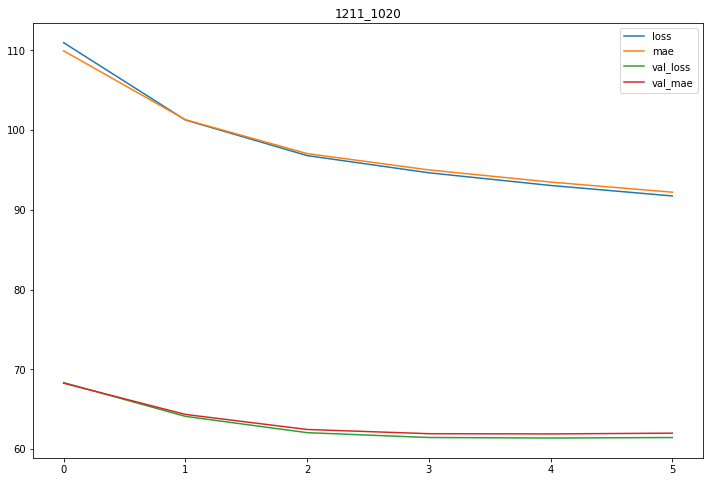

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1020'
model_name = 'KDI-s_KDI-xs_Dense-ReLU-l2reg'
model_structure = create_model_10
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.00007
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-ReLU-l1l2reg/20221211-103018
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-ReLU-l1l2reg/20221211-103018
Epoch 1/20
5500/5500 [==============================] - 69s 12ms/step - loss: 109.8191 - mae: 110.3169 - val_loss: 67.2503 - val_mae: 67.7601
Epoch 2/20
5500/5500 [==============================] - 63s 12ms/step - loss: 103.5494 - mae: 104.0585 - val_loss: 64.8345 - val_mae: 65.3568
Epoch 3/20
5500/5500 [==============================] - 64s 12ms/step - loss: 99.0374 - mae: 99.5551 - val_loss: 62.6614 - val_mae: 63.2005
Epoch 4/20
5500/5500 [==============================] - 64s 12ms/step - loss: 96.1922 - mae: 96.7241 - val_loss: 61.7121 - val_mae: 62.2670
Epoch 5/20
5500/5500 [==============================] - 64s 12ms/step - loss: 94.5436 - mae: 95.0891 - val_loss: 61.2459 - val_mae: 61.8133
Epoch 6/20
5500/5500 [==

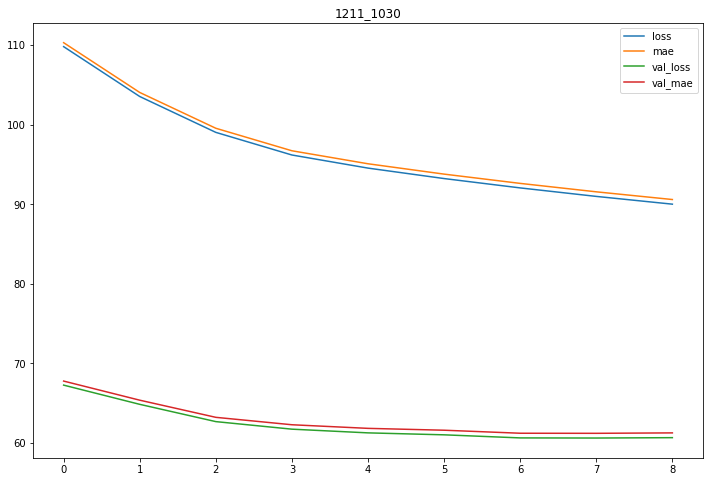

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1030'
model_name = 'KDI-s_KDI-xs_Dense-ReLU-l1l2reg'
model_structure = create_model_11
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.00007
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-ReLU-noreg/20221211-104306
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-ReLU-noreg/20221211-104306
Epoch 1/20
5500/5500 [==============================] - 72s 13ms/step - loss: 109.3573 - mae: 110.0467 - val_loss: 68.0391 - val_mae: 68.7277 - lr: 7.0000e-05
Epoch 2/20
5500/5500 [==============================] - 63s 11ms/step - loss: 103.3406 - mae: 104.0296 - val_loss: 65.7987 - val_mae: 66.4875 - lr: 1.0000e-04
Epoch 3/20
5500/5500 [==============================] - 67s 12ms/step - loss: 98.8823 - mae: 99.5710 - val_loss: 87.4955 - val_mae: 88.1863 - lr: 4.0000e-04
Time Elapsed During Training (in ms): 202.23788285255432


reach lr but cannot plot


1/1 [==============================] - 0s 421ms/step
The evaluation results are: 
 Loss: 88.57234954833984
 Metrics: [89.26338195800781]

         PL
count  32.0
mean   72

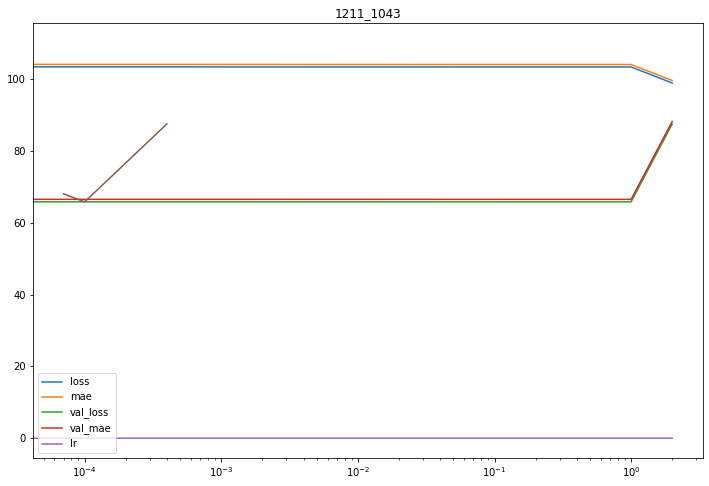

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1043'
model_name = 'KDI-s_KDI-xs_Dense-ReLU-noreg'
model_structure = create_model_12
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

# lr = 0.00009
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
lr_scheduler = prep.create_lr_scheduler(0.01)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

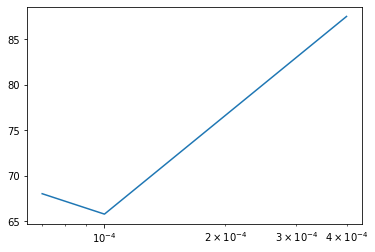

In [ ]:
prep.lr_vs_loss(history)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-s_KDI-xs_Dense-ReLU-noreg/20221211-104733
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-s_KDI-xs_Dense-ReLU-noreg/20221211-104733
Epoch 1/20
5500/5500 [==============================] - 70s 13ms/step - loss: 109.3756 - mae: 110.0646 - val_loss: 68.9971 - val_mae: 69.6856
Epoch 2/20
5500/5500 [==============================] - 68s 12ms/step - loss: 103.7178 - mae: 104.4070 - val_loss: 65.6130 - val_mae: 66.3008
Epoch 3/20
5500/5500 [==============================] - 69s 13ms/step - loss: 100.4449 - mae: 101.1336 - val_loss: 63.7876 - val_mae: 64.4752
Epoch 4/20
5500/5500 [==============================] - 68s 12ms/step - loss: 97.6457 - mae: 98.3344 - val_loss: 62.0617 - val_mae: 62.7494
Epoch 5/20
5500/5500 [==============================] - 67s 12ms/step - loss: 95.3370 - mae: 96.0254 - val_loss: 61.2388 - val_mae: 61.9262
Epoch 6/20
5500/5500 [====

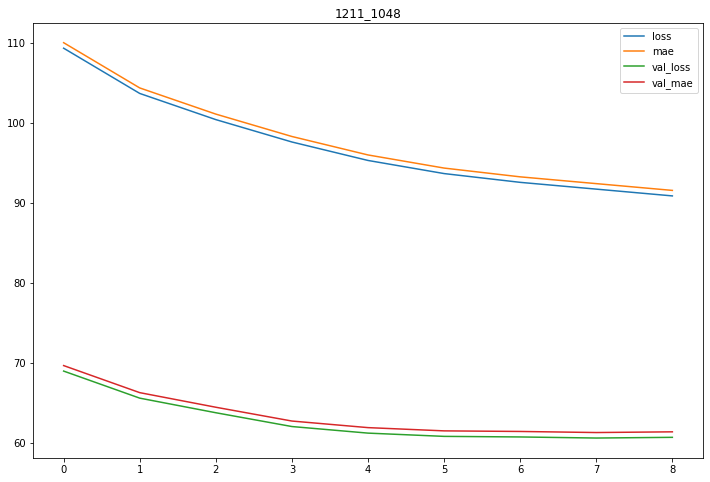

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1048'
model_name = 'KDI-s_KDI-xs_Dense-ReLU-noreg'
model_structure = create_model_12
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.00009
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
# loss = tf.keras.losses.MeanAbsoluteError()
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-1s_KDI-xs_GRU/20221211-115224
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-1s_KDI-xs_GRU/20221211-115224
Epoch 1/20
5500/5500 [==============================] - 127s 22ms/step - loss: 160.9318 - mae: 160.9318 - val_loss: 84.4511 - val_mae: 84.4511 - lr: 7.0000e-05
Epoch 2/20
5500/5500 [==============================] - 127s 23ms/step - loss: 118.6338 - mae: 118.6338 - val_loss: 73.1880 - val_mae: 73.1880 - lr: 1.0000e-04
Epoch 3/20
5500/5500 [==============================] - 120s 22ms/step - loss: 109.5133 - mae: 109.5133 - val_loss: 68.9248 - val_mae: 68.9248 - lr: 4.0000e-04
Epoch 4/20
5500/5500 [==============================] - 123s 22ms/step - loss: 106.7775 - mae: 106.7775 - val_loss: 71.1568 - val_mae: 71.1568 - lr: 7.0000e-04
Time Elapsed During Training (in ms): 498.2802288532257


reach lr but cannot plot


1/1 [==========================

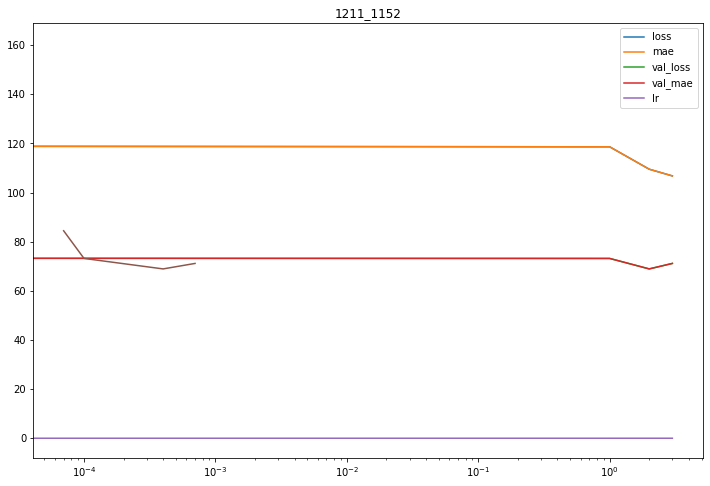

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1152'
model_name = 'KDI-1s_KDI-xs_GRU'
model_structure = create_model_13
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

# lr = 0.00009
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
lr_scheduler = prep.create_lr_scheduler(0.01)
optimizer = tf.keras.optimizers.Adam()
# loss = tf.keras.losses.LogCosh()
loss = 'mae'
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)

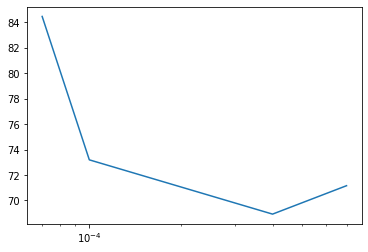

In [ ]:
prep.lr_vs_loss(history)

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/KDI-1s_KDI-xs_GRU/20221211-120159
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/KDI-1s_KDI-xs_GRU/20221211-120159
Epoch 1/20
5500/5500 [==============================] - 130s 23ms/step - loss: 131.4819 - mae: 131.4819 - val_loss: 84.4406 - val_mae: 84.4406
Epoch 2/20
5500/5500 [==============================] - 120s 22ms/step - loss: 119.5568 - mae: 119.5568 - val_loss: 71.9466 - val_mae: 71.9466
Epoch 3/20
5500/5500 [==============================] - 125s 23ms/step - loss: 110.8991 - mae: 110.8991 - val_loss: 70.8196 - val_mae: 70.8196
Epoch 4/20
5500/5500 [==============================] - 126s 23ms/step - loss: 108.9162 - mae: 108.9162 - val_loss: 70.1525 - val_mae: 70.1525
Epoch 5/20
5500/5500 [==============================] - 124s 23ms/step - loss: 110.1588 - mae: 110.1588 - val_loss: 70.8569 - val_mae: 70.8569
Time Elapsed During Training (in ms): 626

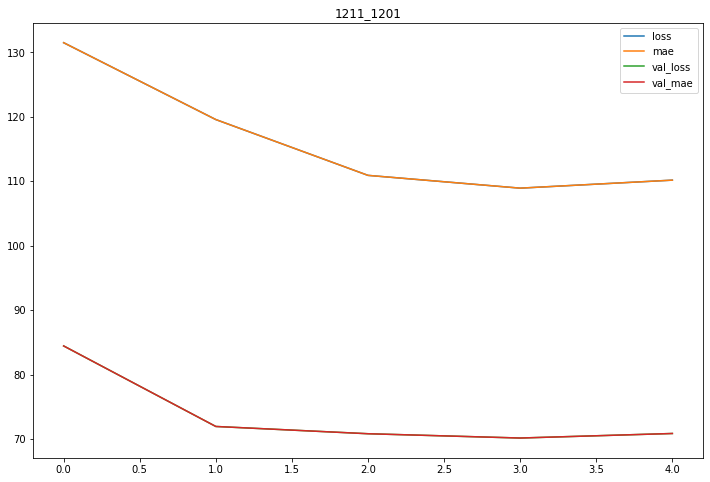

In [ ]:
## main_training

##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##
l1_reg = None
train_id = '1211_1201'
model_name = 'KDI-1s_KDI-xs_GRU'
model_structure = create_model_13
##--------------------CHECK EVERY TIME WHEN RUNNING THIS BLOCK OF CODE--------------------##

lr = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# lr_scheduler = prep.create_lr_scheduler(0.01)
# optimizer = tf.keras.optimizers.Adam()
# loss = tf.keras.losses.LogCosh()
loss = 'mae'
metrics = ['mae']
EPOCHS = 20
patience = 1
callbacks = prep.get_callbacks(model_name, patience, avg_mode)
# callbacks = [lr_scheduler] + callbacks
model, history = main_training(model_name, train_id, model_structure,
                               input_format, train_KD,
                               optimizer, loss, metrics, l1_reg, mat_length,
                               trainset, devset, EPOCHS, callbacks)
eval_results, diff = print_results(model, testset, input_format, test_KD, output_features)